# Week 2: Essential 2D Transforms & Filters

In [1]:
import numpy as np
import scipy as sp
import imageio
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.dpi':300})

# Radon transform

In [2]:
## Helpers

def show_imvals(ax, img):
    """for nice image plotting with intensity labels"""
    imnorm = img - np.min(img)
    if np.std(imnorm)>0:
        imnorm = imnorm / np.max(imnorm)
    Nk, Nk = imnorm.shape
    ax.imshow(imnorm, cmap='gray', vmin=-1,vmax=1,extent=(0,Nk,0,Nk))
    ax.set_xticks(range(Nk+1))
    ax.set_yticks(range(Nk+1))
    ax.grid(which='both',color='k')
    
    # label vals
    fsz = 12*3/Nk
    for i in range(Nk):
        for j in range(Nk):
            ax.text(i+0.5,j+0.5,img[::-1, :][j,i],fontsize=fsz,  ha='center', va='center')

class Phantom2D:
    """Class to handle input phantom and corresponding params. """
    def __init__(self, M, dtype=np.uint8):
        self.M = M
        self.Ny, self.Nx = self.M.shape

def raytrace(phantom, phi, xi, dl=0.1, plot=False):
    """a function to retrieve a single line integral through a 2D matrix"""
    # initialize rotated P0, Pf (start and end points for ray)
    rotation_matrix = np.array([[np.cos(phi), -np.sin(phi)],
                                [np.sin(phi), np.cos(phi)]])
    P0 = rotation_matrix@np.array([xi, phantom.Nx])
    Pf = rotation_matrix@np.array([xi, -phantom.Nx])
    Px, Py = np.array([P0,Pf]).T + [phantom.Nx/2,phantom.Nx/2]
    P0, Pf = np.array([Px,Py]).T # shifted to phantom indexing (0->Nx, 0->Ny)
    
    # get evaluation points for line profile 
    points = []
    for n in range(-int(2*phantom.Nx/dl),int(2*phantom.Nx/dl)):
        point = P0 + n*dl*np.array([np.cos(phi+np.pi/2),np.sin(phi+np.pi/2)])
        if point[0]>0 and point[0]<phantom.Nx and point[1]>0 and point[1]<phantom.Ny:
            points.append(point)

    # calculate the line profile
    values = []
    for point in points:
        px, py = point
        ix, iy = int(px), int(phantom.Ny-py)
        values.append(phantom.M[iy,ix])
    
    if plot:
        # create plot to visualize
        fig,ax=plt.subplots(1,2, figsize=[6,3], facecolor='w')
        
        ax[0].set_title('object')
        ax[1].set_title('line profile')

        ax[0].plot(Px, Py, 'ro-')
        show_imvals(ax[0] ,phantom.M)

        ax[1].plot(dl*np.arange(len(values)), values, 'r-')
        ax[1].set_ylim(np.min(phantom.M)-0.2,np.max(phantom.M)+0.2)
        #plt.savefig('examples/line_profile.png')
        plt.show()
    
    return np.sum(values)*dl # line integral

def RT2D(phantom, Nxi=20, Nphi=20, plot_sino=True, get_sino=False):
    """a function to calculate and show the 2D Radon Transform of a 2D matrix"""
    # make a sinogram
    N = np.min([phantom.Nx, phantom.Ny])
    xi_vals = np.linspace(-N/2+.1, N/2-.1, Nxi)  # bounds must be within +-N/2 !!
    phi_vals = np.linspace(0, 2*np.pi, Nphi)
    sino = np.zeros([len(phi_vals), len(xi_vals)])
    for i,xi in enumerate(xi_vals):
        for j,phi in enumerate(phi_vals):
            sino[j,i] = raytrace(phantom, phi, xi)
    if plot_sino:
        fig,ax=plt.subplots(1, 2, figsize=[6,3], facecolor='w')
        ax[0].imshow(phantom.M)
        ax[0].set_xlabel('$x$')
        ax[0].set_ylabel('$y$')
        ax[0].set_title('object $f(x,y)$')
        ax[1].imshow(sino, 
                  extent=(min(xi_vals),max(xi_vals), min(phi_vals),max(phi_vals)), 
                  aspect=(max(xi_vals)-min(xi_vals))/(max(phi_vals)-min(phi_vals)))
        ax[1].set_xlabel(r'$\xi$')
        ax[1].set_ylabel(r'$\phi$')
        ax[1].set_title(r'sinogram $p(\xi,\phi)$')
        fig.tight_layout()
        #plt.savefig('examples/sino.png')
        plt.show()
    if get_sino:
        return sino

## Single line profiles

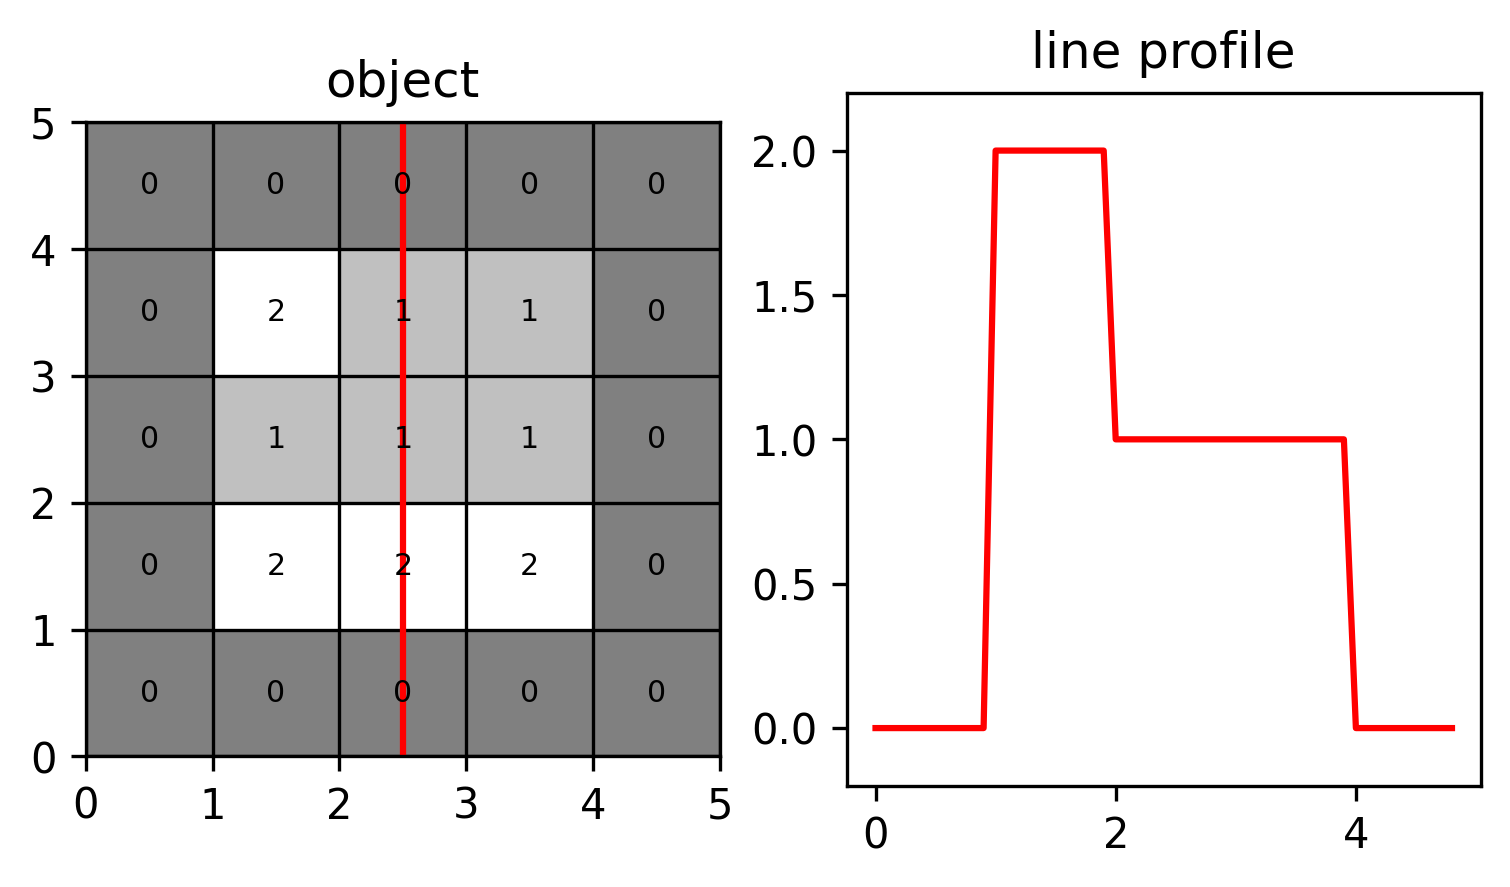

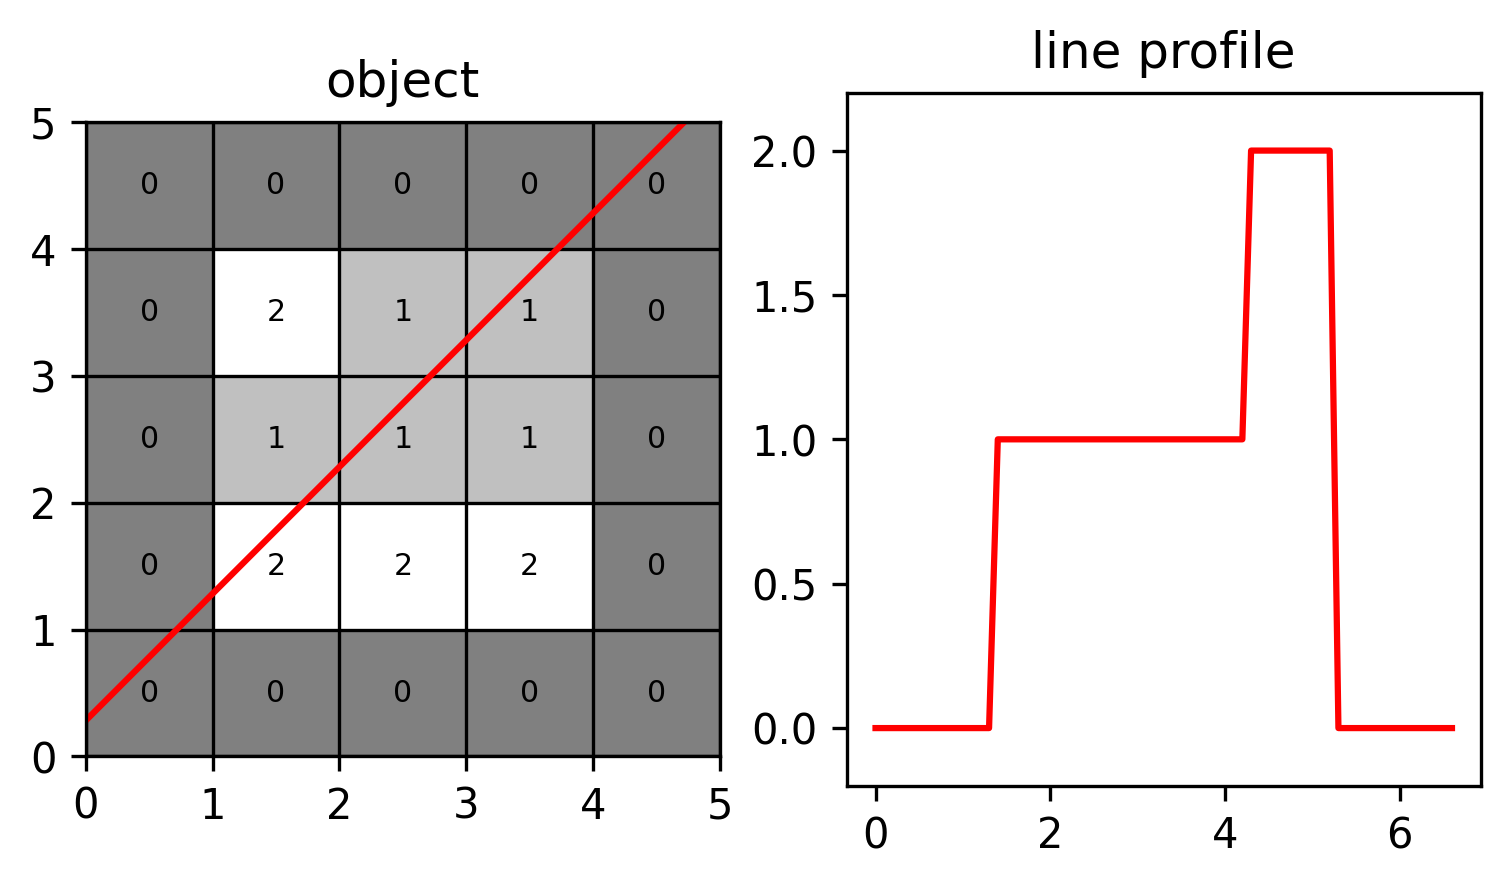

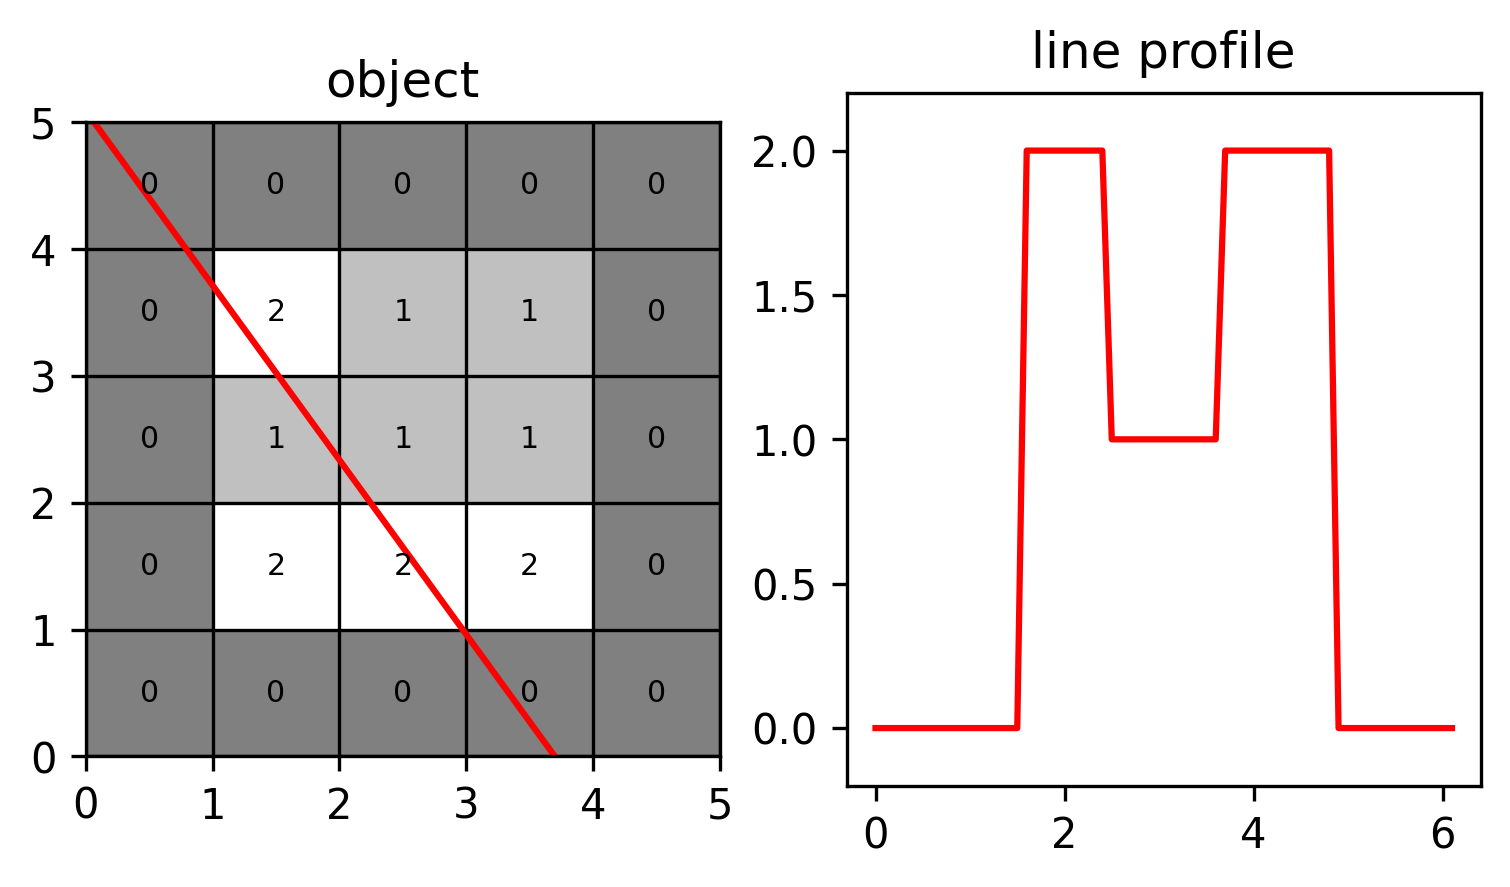

CPU times: user 341 ms, sys: 27 ms, total: 368 ms
Wall time: 366 ms


np.float64(5.4)

In [3]:
%%time

# test a few line profiles
phantom = Phantom2D(np.array([[0,0,0,0,0],
                           [0,2,1,1,0],
                           [0,1,1,1,0],
                           [0,2,2,2,0],
                           [0,0,0,0,0]]))

raytrace(phantom,   0*np.pi,   0, plot=True)
raytrace(phantom, .75*np.pi, 0.2, plot=True)
raytrace(phantom, 1.2*np.pi, 0.5, plot=True)

## Full sinograms

### point sources

Do you remember the analytical expression for the Radon transform of a point source? (Or, can you derive it?)

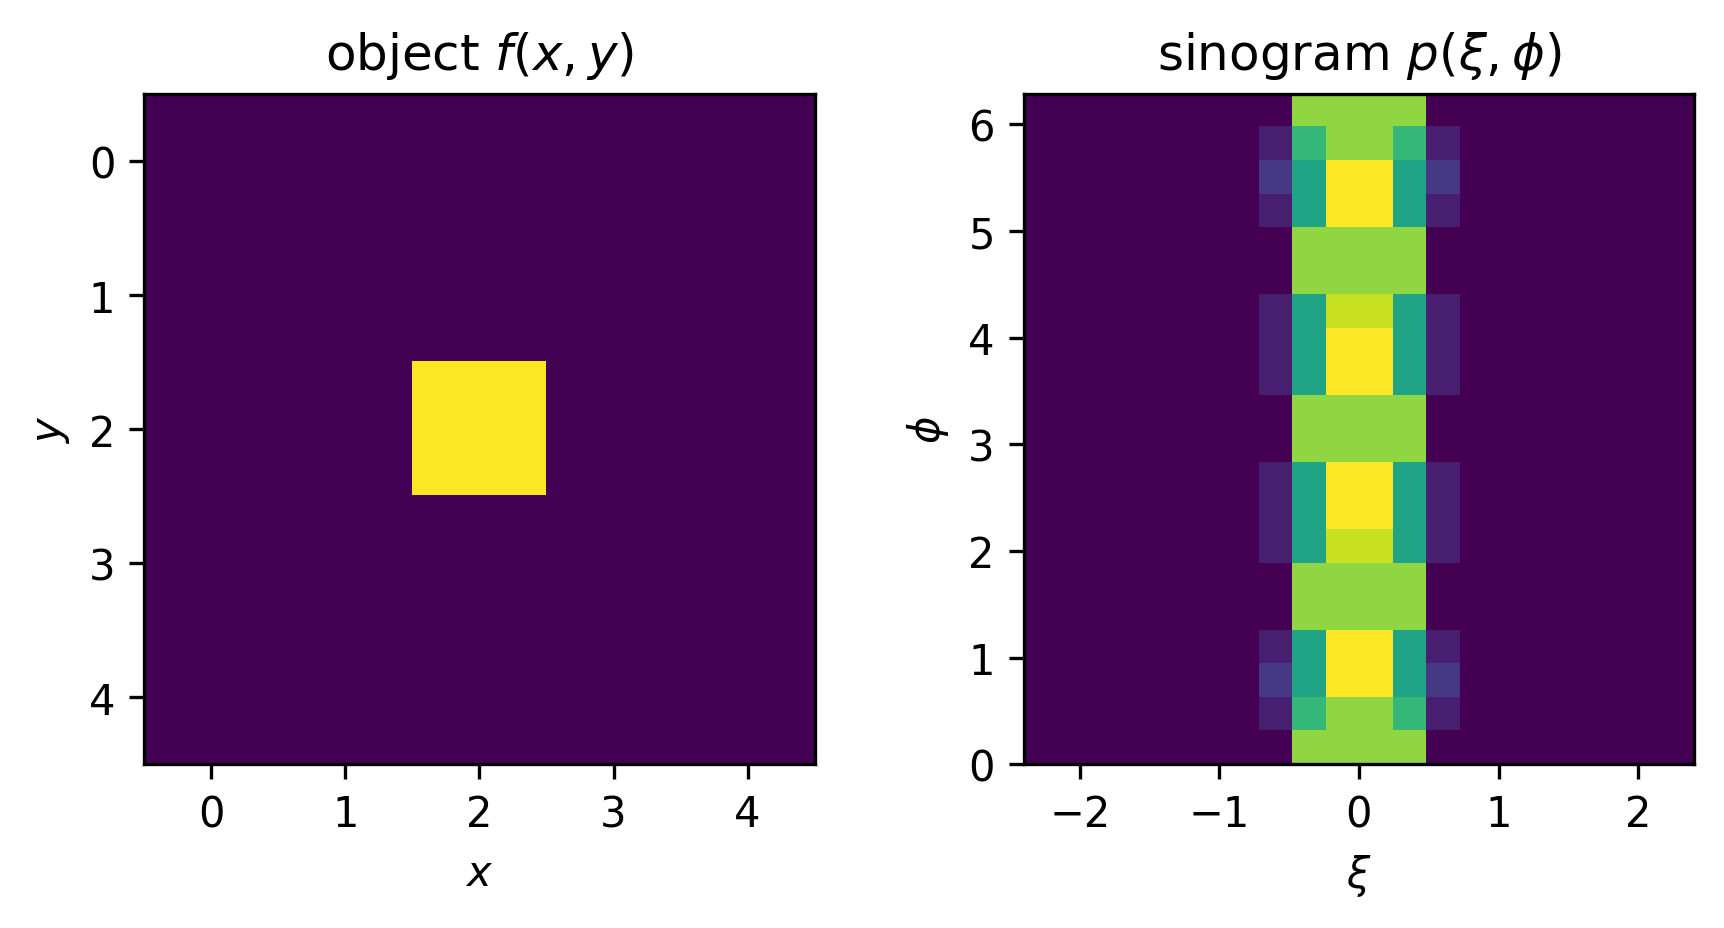

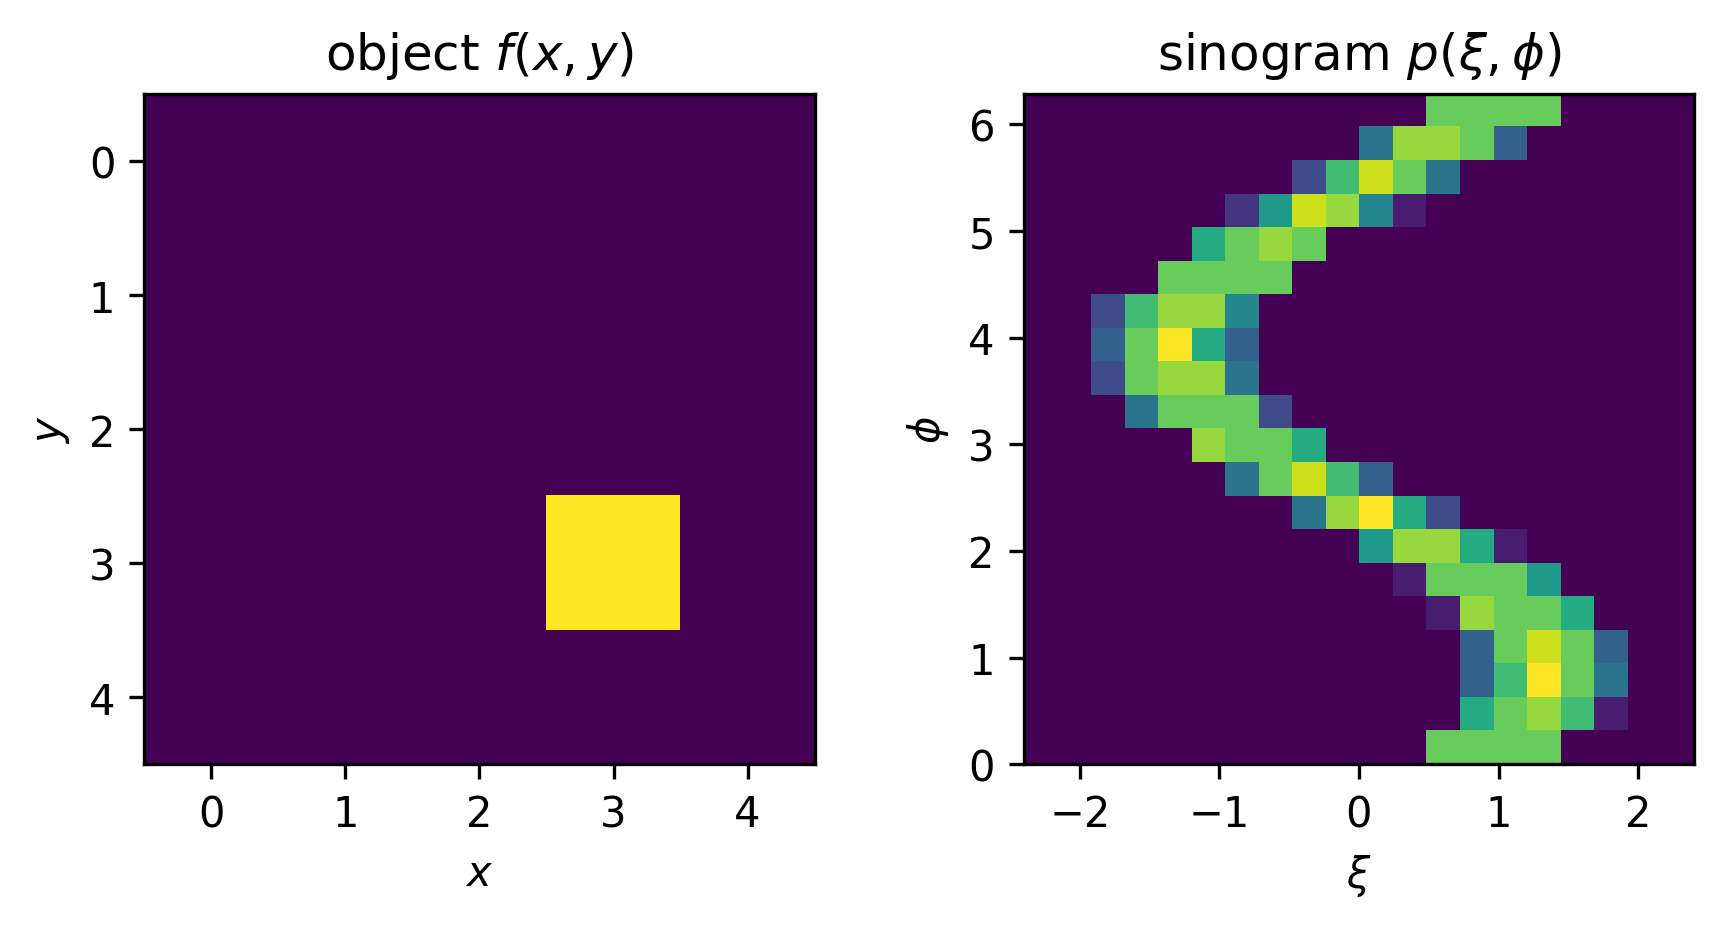

In [4]:
point_center = Phantom2D(np.array([[0,0,0,0,0],
                                  [0,0,0,0,0],
                                  [0,0,1,0,0],
                                  [0,0,0,0,0],
                                  [0,0,0,0,0]]))
point_skew   = Phantom2D(np.array([[0,0,0,0,0],
                                  [0,0,0,0,0],
                                  [0,0,0,0,0],
                                  [0,0,0,1,0],
                                  [0,0,0,0,0]]))

for point in [point_center, point_skew]:
    RT2D(point)

# bigger objects

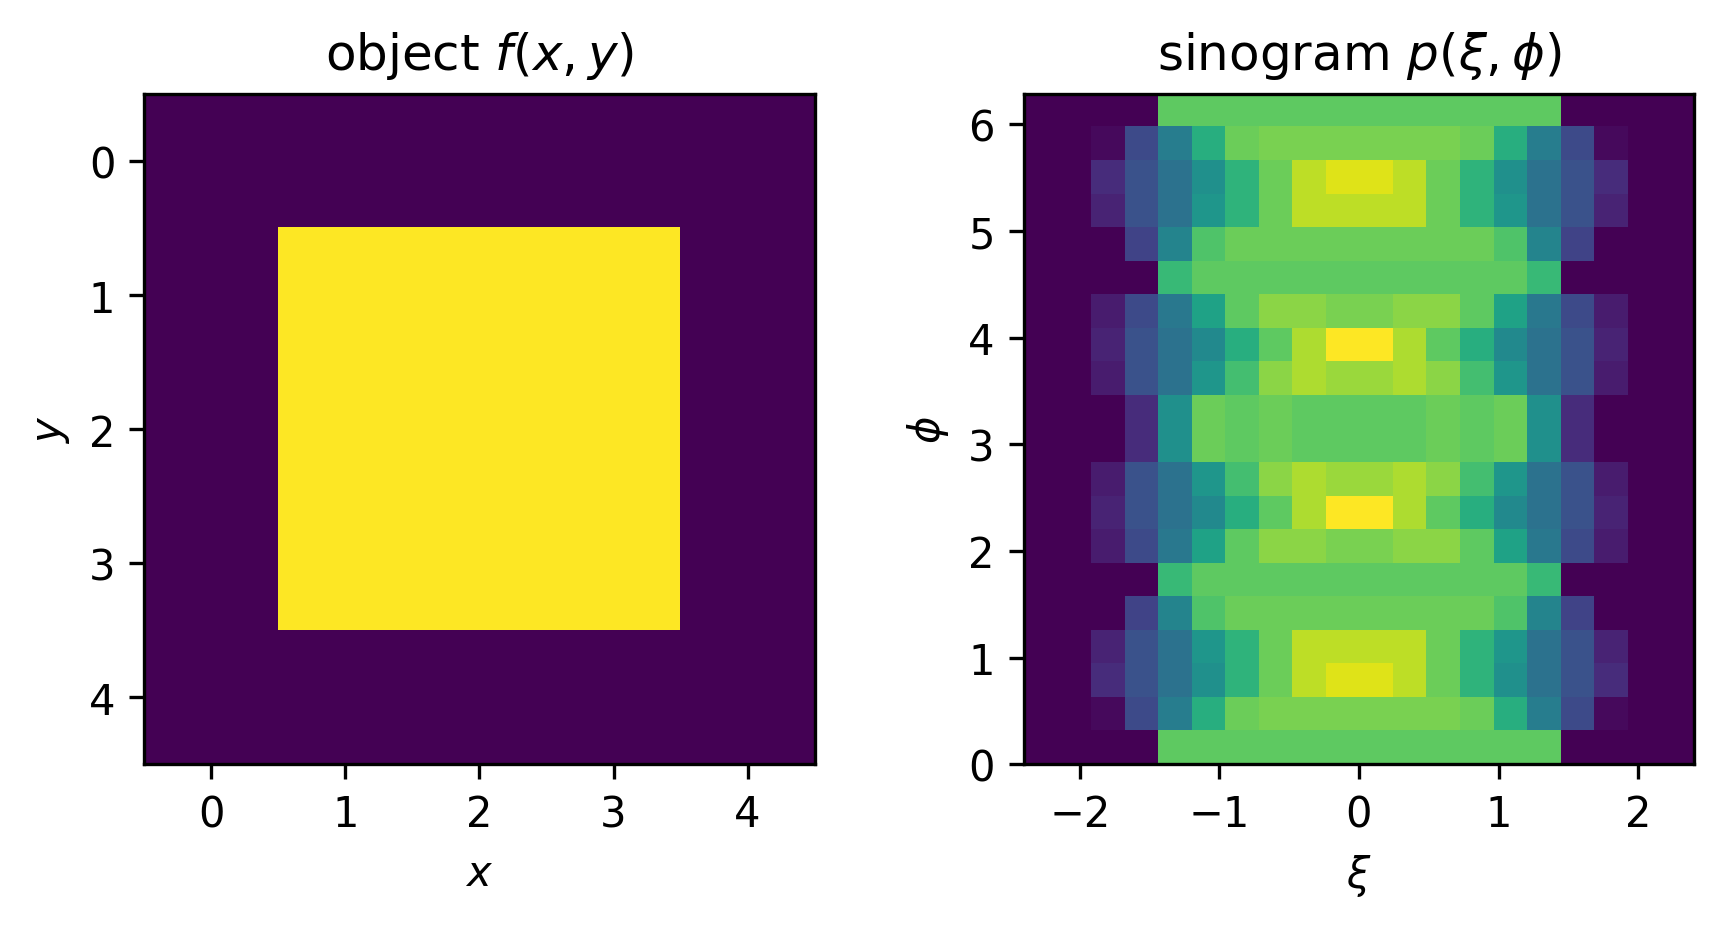

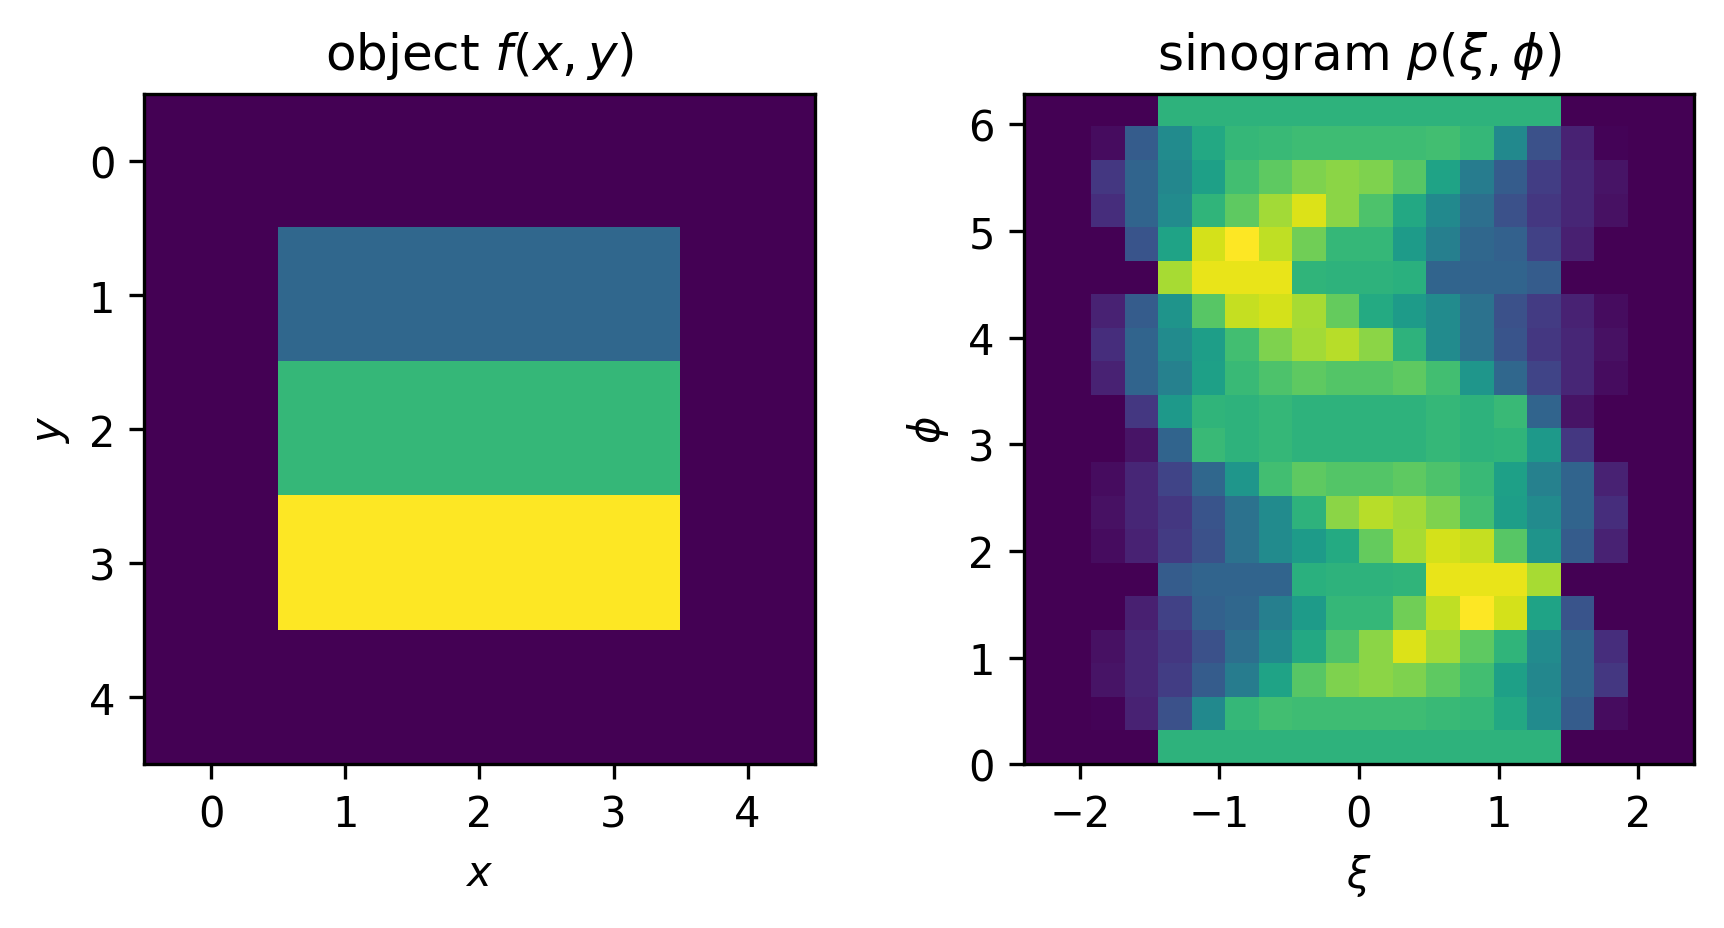

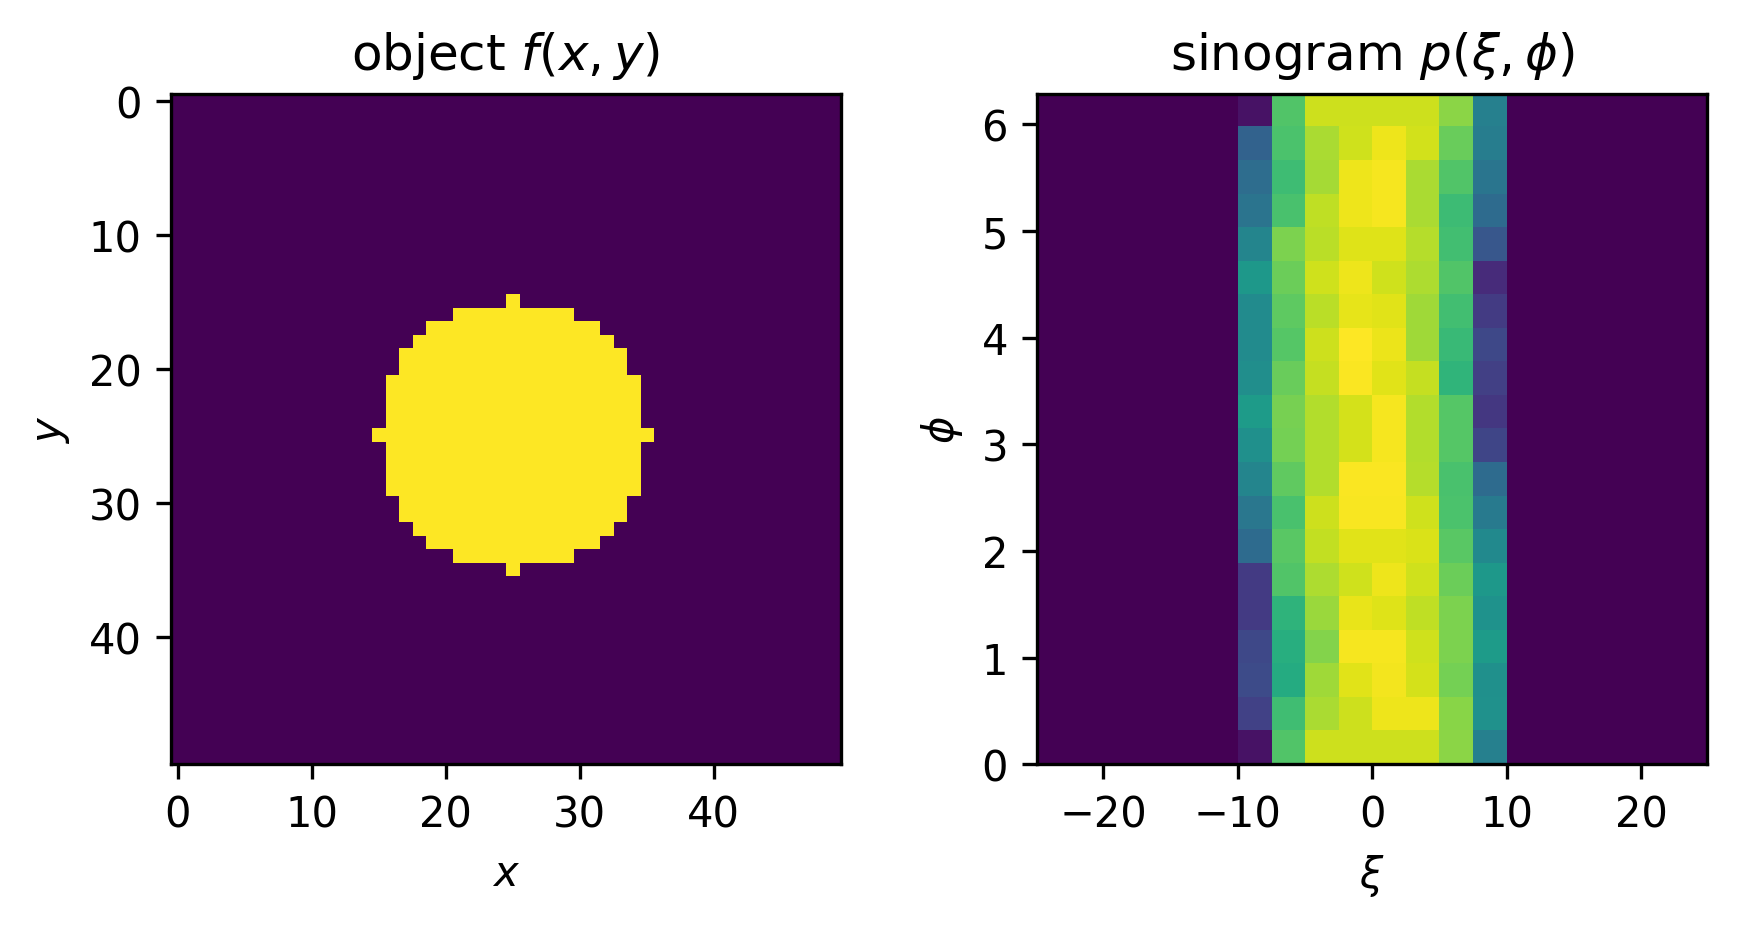

CPU times: user 2.79 s, sys: 44.5 ms, total: 2.84 s
Wall time: 2.85 s


In [5]:
%%time 

square_uniform = Phantom2D(np.array([[0,0,0,0,0],
                                   [0,1,1,1,0],
                                   [0,1,1,1,0],
                                   [0,1,1,1,0],
                                   [0,0,0,0,0]]))

square_nonuni = Phantom2D(np.array([[0,0,0,0,0],
                                   [0,1,1,1,0],
                                   [0,2,2,2,0],
                                   [0,3,3,3,0],
                                   [0,0,0,0,0]]))

N = 50
circle = np.zeros([N,N])
radius = 10
for i in range(N):
    for j in range(N):
        if np.sqrt((i-N/2)**2 + (j-N/2)**2)<=radius:
            circle[i,j]=1
            
circle_phantom = Phantom2D(circle)

for phant in [square_uniform, square_nonuni, circle_phantom]:
    RT2D(phant)


# Fourier transform

Scipy has a variety of useful FFT (fast Fourier transform) functions you can implement:

https://docs.scipy.org/doc/scipy/reference/fftpack.html

Make sure you know when to use each; for example, the rfft versus regular fft. Is the output real or complex? There are also corresponding inverse functions irfft and ifft. 

For our 2D transforms, we'll be using fft2. There is no scipy rfft2 currently.

(339, 508)


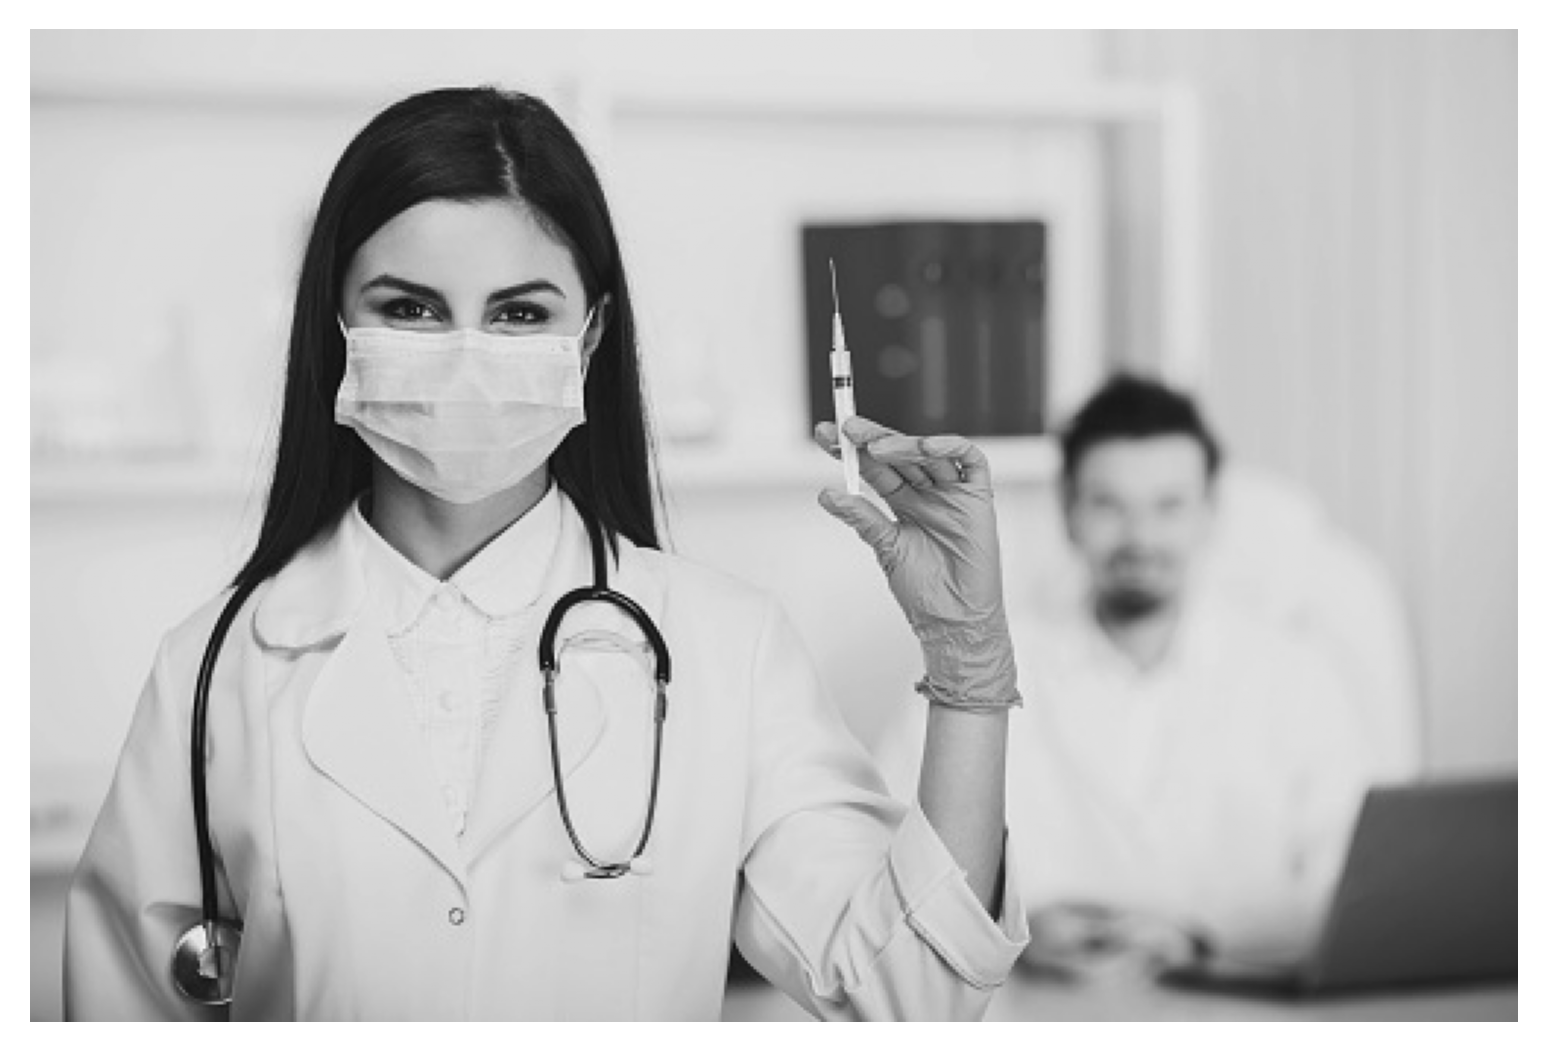

In [6]:
filename = 'imgs/stock1.jpg' 
img = Image.open(filename)
data_rgb = np.asarray(img, dtype='int32')
data = np.mean(data_rgb, axis=2)
if max(data.shape) > 600:  # if big, downsample to save run time
    data = data[::2,::2]

fig, ax = plt.subplots()
ax.imshow(data, cmap='gray')
ax.axis('off')
print(data.shape)
plt.show()

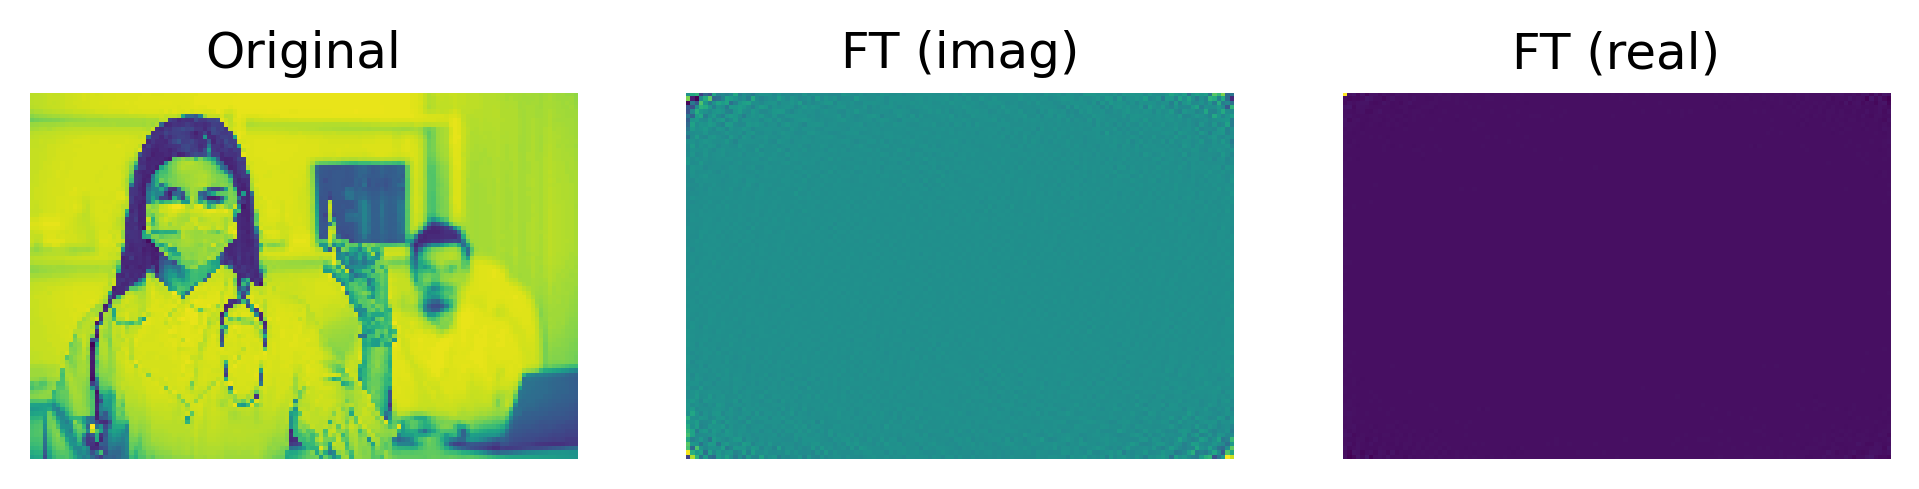

CPU times: user 173 ms, sys: 29.7 ms, total: 203 ms
Wall time: 202 ms


In [7]:
%%time

# downsample for even more time save
test = data[::4,::4]

# take the FFT
test_ft = sp.fftpack.fft2(test)

fig, ax = plt.subplots(1, 3, figsize=(8,3))
ax[0].set_title('Original'); ax[0].imshow(test)
ax[1].set_title('FT (imag)'); ax[1].imshow(test_ft.imag)
ax[2].set_title('FT (real)'); ax[2].imshow(test_ft.real)
for axi in ax:
    axi.axis('off')
plt.show()

Why is the FT empty in the middle? To understand this, we need to know what the axes of the FT represent. First, the FT is symmetric. Second, by default, the 0-frequency origin is in the corner, just like the 0-distance origin in the original picture is in the corner. If we want the 0 frequency in the middle of the image, like we typically draw, we can use fftshift.

This is nice for plotting, but be mindful! Make sure you unshift before inverse transforming.

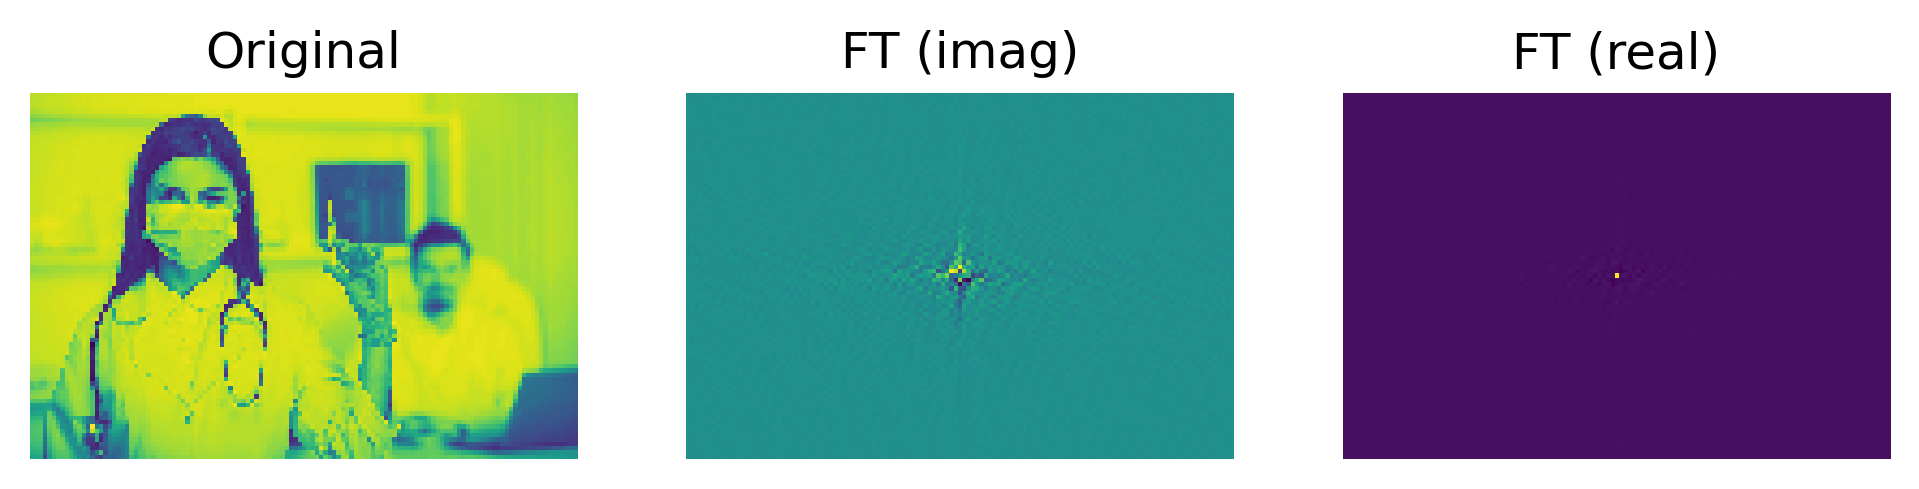

In [8]:
test_ft_shift = sp.fftpack.fftshift(test_ft)

fig, ax = plt.subplots(1, 3, figsize=(8,3))
ax[0].set_title('Original'); ax[0].imshow(test)
ax[1].set_title('FT (imag)'); ax[1].imshow(test_ft_shift.imag)
ax[2].set_title('FT (real)'); ax[2].imshow(test_ft_shift.real)
for axi in ax:
    axi.axis('off')
plt.show()

## inverting back to the original

Remember we have complex data! Take the magnitude. Do you see a difference between the images?

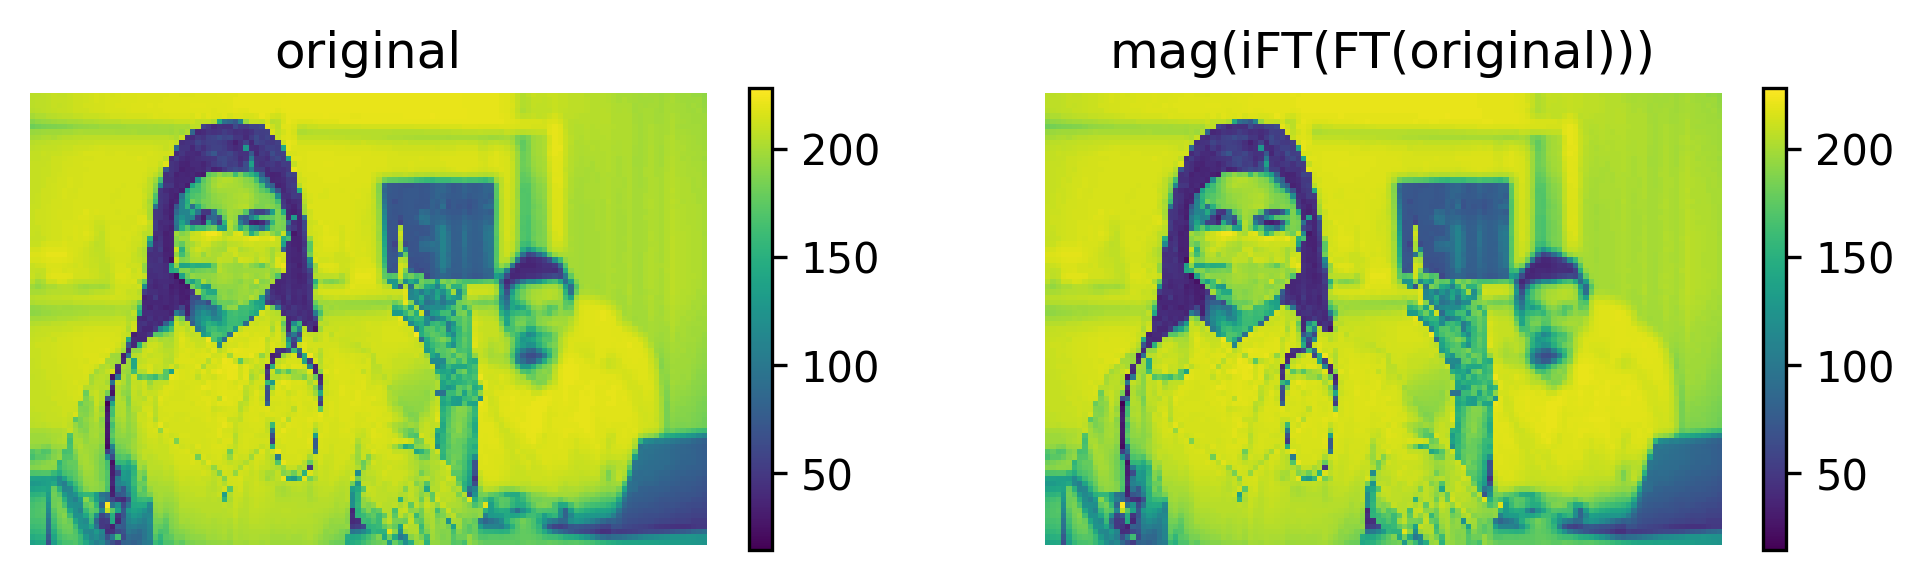

CPU times: user 106 ms, sys: 9.41 ms, total: 115 ms
Wall time: 113 ms


In [9]:
%%time

test_ft = sp.fftpack.fft2(test)
i_test_ft = sp.fftpack.ifft2(test_ft)
i_test_ft = np.sqrt(i_test_ft.real**2 + i_test_ft.imag**2)  # this is upside-down by default

fig, ax = plt.subplots(1, 2, figsize=(8,2))
ax[0].set_title('original'); m = ax[0].imshow(test); fig.colorbar(m, ax=ax[0])
ax[1].set_title('mag(iFT(FT(original)))'); m = ax[1].imshow(i_test_ft); fig.colorbar(m, ax=ax[1])
for axi in ax:
    axi.axis('off')
plt.show()

## Fourier filtration

Sometimes we want to scale up/down the contribution of certain frequency components, or even eliminate them entirely. This can easily be done in Fourier space. One of the best known examples is probably the CT filtered-back projection ramp filter. But, there are plenty more applications!

This uses the "convolution-multiplication" theorem. We cover convolution below. The main idea is, to filter in Fourier space, we multiply by a frequency-space kernel.

When working with real images, be careful to make sure you use Fourier frequencies that correspond to your REAL image size, not the integer units counting each pixel. This can have disastrous consequences if ignored.

(85, 127)


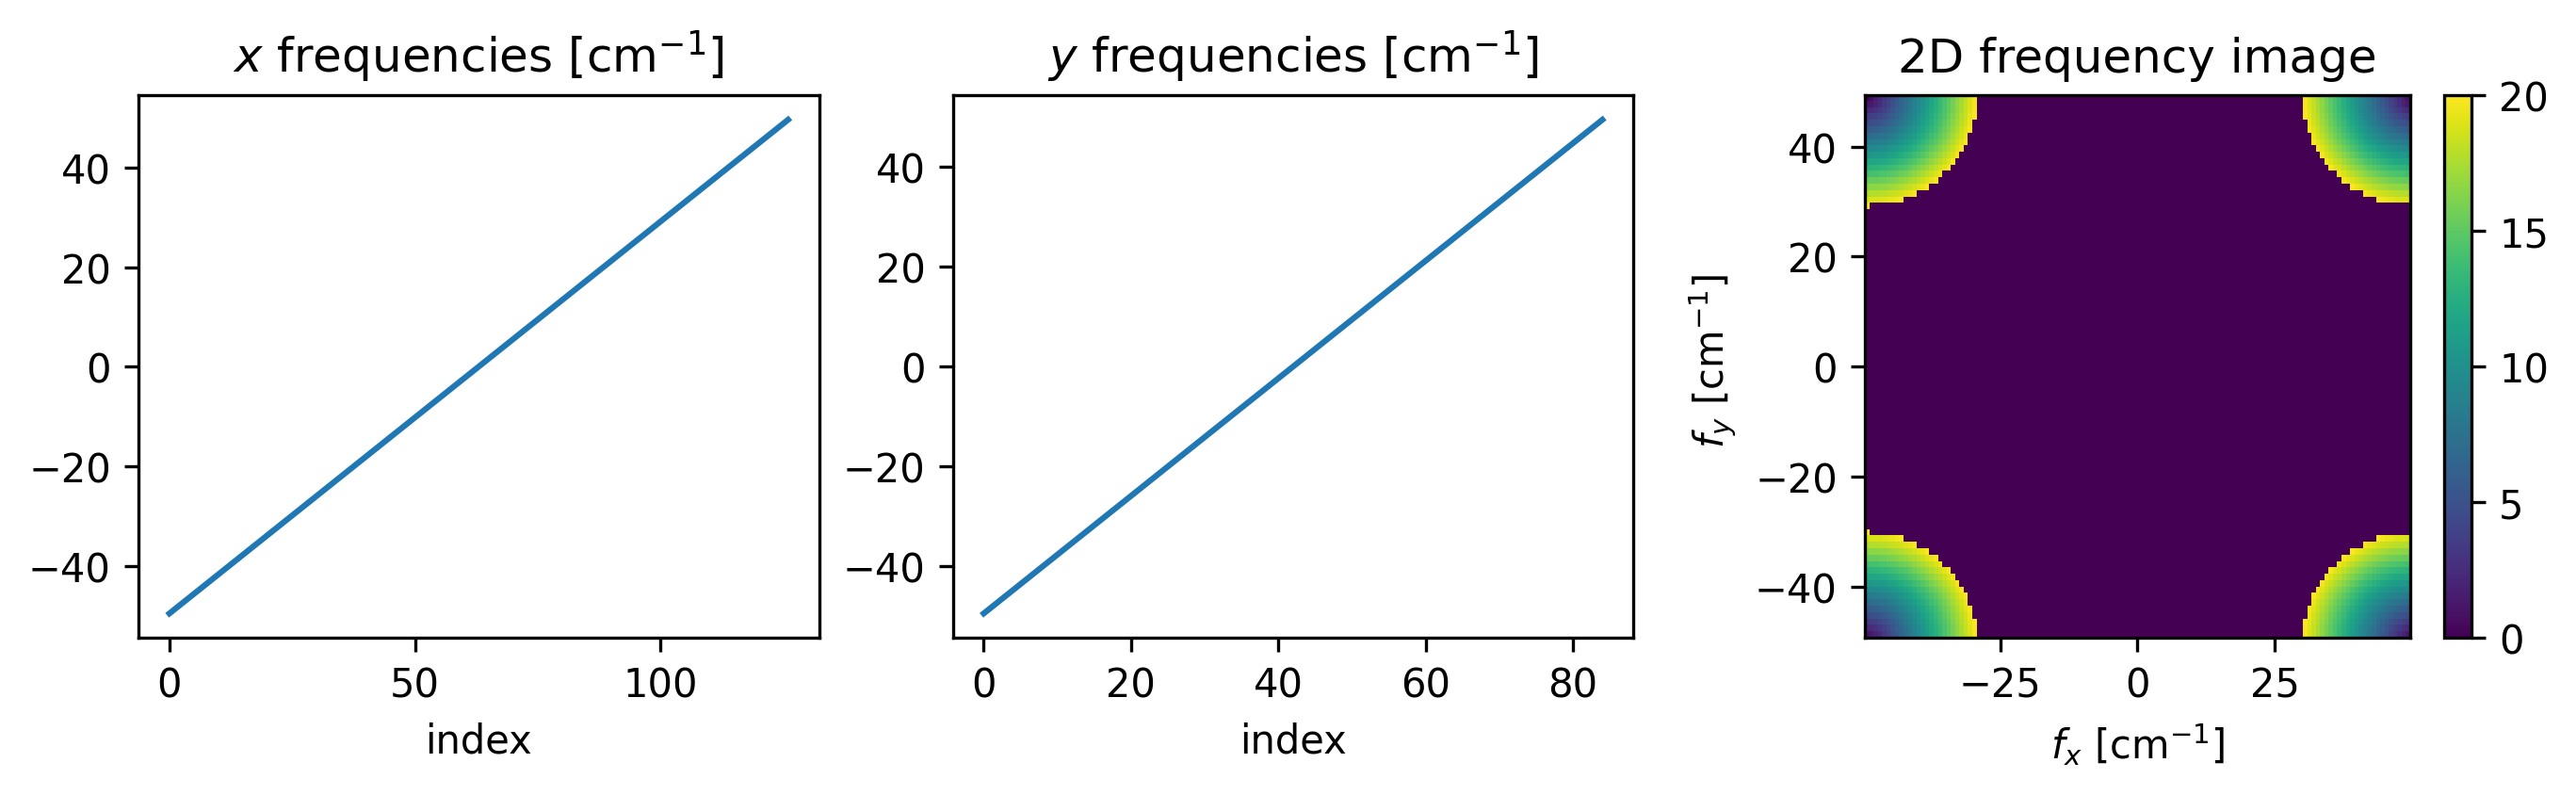

In [10]:
# 2D frequency components

dx = 1e-2  # let's make our pixel size 1 cm. 

xfreq = sp.fftpack.fftfreq(test.shape[1], d=dx)
yfreq = sp.fftpack.fftfreq(test.shape[0], d=dx)
FX, FY = np.meshgrid(xfreq, yfreq)
freq2d = np.sqrt(FX**2 + FY**2)
freq2d[freq2d > 20] = 0
print(freq2d.shape)

fig, ax = plt.subplots(1, 3, figsize=(9,2.7), layout='constrained')
ax[0].set_title(r'$x$ frequencies [cm$^{-1}$]'); ax[0].plot(sp.fftpack.fftshift(xfreq)); ax[0].set_xlabel('index')
ax[1].set_title(r'$y$ frequencies [cm$^{-1}$]'); ax[1].plot(sp.fftpack.fftshift(yfreq)); ax[1].set_xlabel('index')
ax[2].set_title('2D frequency image')
m = ax[2].imshow(freq2d, extent=(FX.min(), FX.max(), FY.min(), FY.max()))
ax[2].set_xlabel(r'$f_x$ [cm$^{-1}$]'); ax[2].set_ylabel(r' $f_y$ [cm$^{-1}$]')
fig.colorbar(m, ax=ax[2])
plt.show()

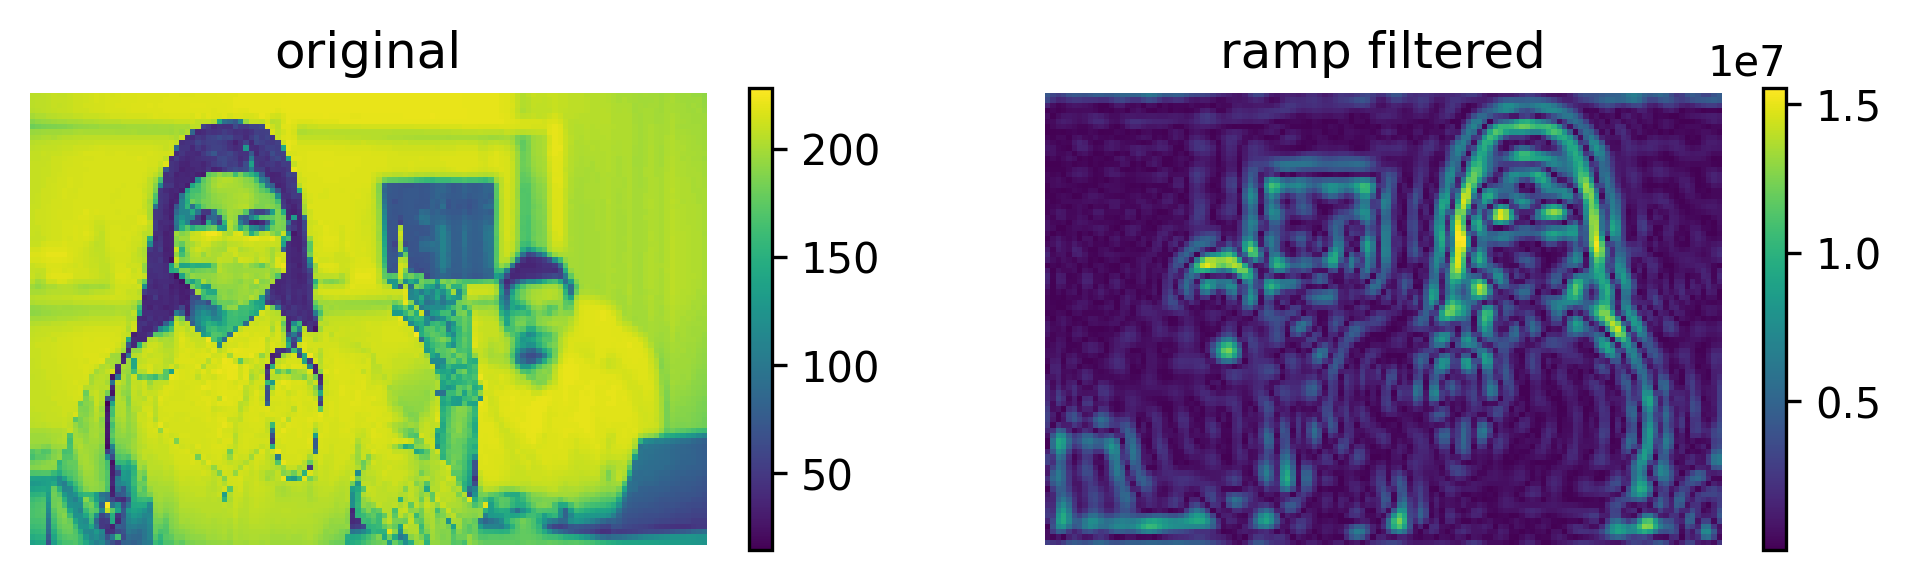

CPU times: user 107 ms, sys: 8.4 ms, total: 115 ms
Wall time: 113 ms


In [11]:
%%time

# Make and apply the filter.
ft_filter = freq2d  # simple ramp

test_ft = sp.fftpack.fft2(test)
test_ft_filtered = test_ft * ft_filter
i_test_ft = sp.fftpack.fft2(test_ft_filtered)
i_test_ft = np.sqrt(i_test_ft.real**2 + i_test_ft.imag**2)[::-1,:]  # this is upside-down by default

fig, ax = plt.subplots(1, 2, figsize=(8,2))
ax[0].set_title('original'); m = ax[0].imshow(test); fig.colorbar(m, ax=ax[0])
ax[1].set_title('ramp filtered'); m = ax[1].imshow(i_test_ft); fig.colorbar(m, ax=ax[1])
for axi in ax:
    axi.axis('off')
plt.show()

Discuss: why does it look that way? Which frequency components does the ramp strengthen?

# Convolution

Different filters have different uses! See some examples.

In [12]:
## Helpers

def convolve_2D(M,k):
    """
    This gives you an idea of how to DIY a convolution.
    But scipy has a better function that is probably faster.
    """
    M = np.array(M)
    Ny, Nx = M.shape
    Nk, Nk = k.shape  # hopefully this is odd and square
    dk = Nk//2
    result = np.zeros(M.shape)
    for j in range(dk,Ny-dk):
        for i in range(dk,Nx-dk):
            for jk in range(Nk):
                for ik in range(Nk):
                    result[j,i] += M[j-dk+jk, i-dk+ik]*k[jk,ik]   
    return result
                    
def show_kernel(ax, kernel):
    """
    for nice kernel plotting with number labels
    """
    knorm = kernel - np.min(kernel)
    if np.std(knorm)>0:
        knorm = knorm / np.max(knorm)
    Nk, Nk = knorm.shape
    ax.imshow(knorm, cmap='gray', vmin=-1,vmax=1,extent=(0,Nk,0,Nk))
    ax.set_xticks(range(Nk+1))
    ax.set_yticks(range(Nk+1))
    ax.grid(which='both',color='k')
    
    # label vals
    fsz = 12*3/Nk
    for i in range(Nk):
        for j in range(Nk):
            ax.text(i+0.5,j+0.5,kernel[j,i],fontsize=fsz,  ha='center', va='center')

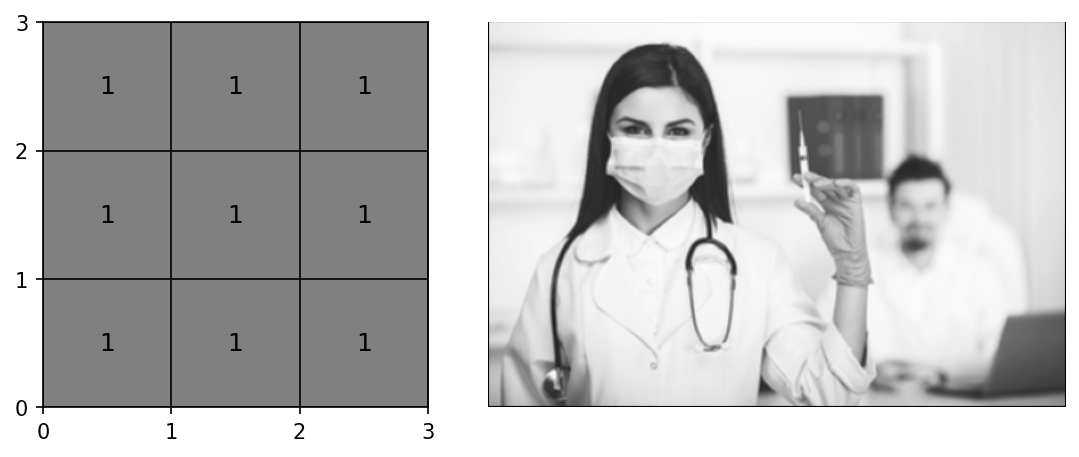

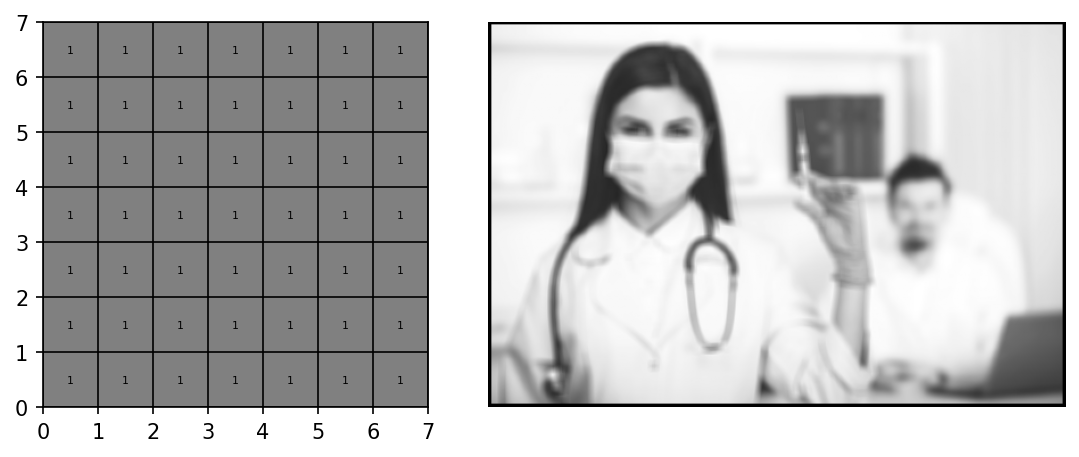

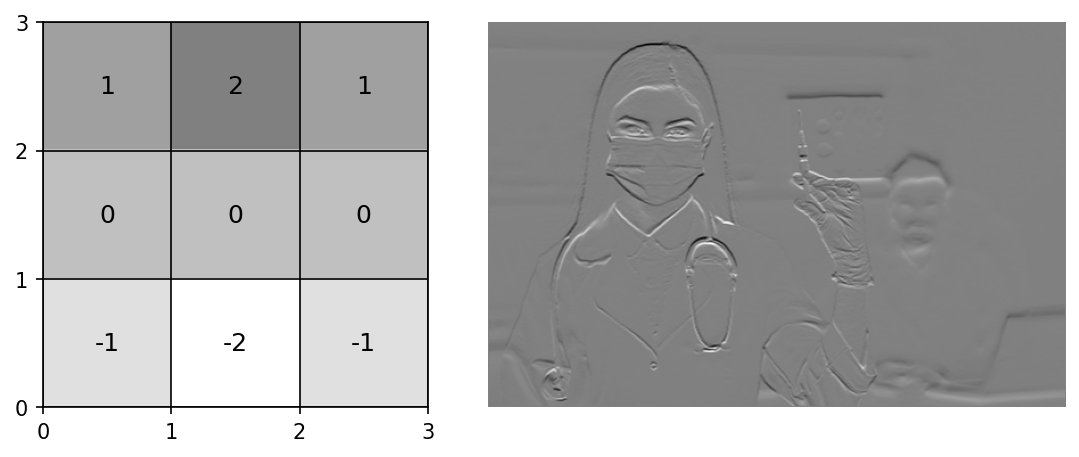

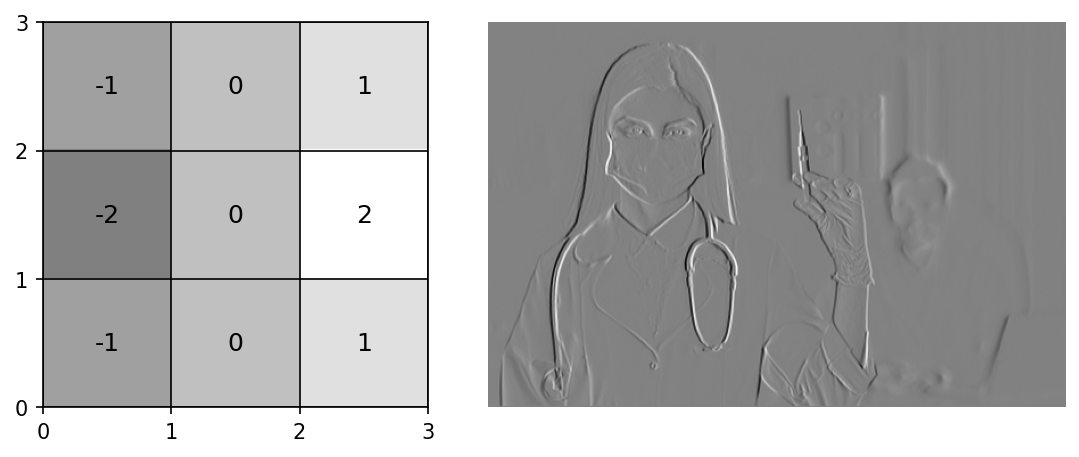

CPU times: user 5.31 s, sys: 39.7 ms, total: 5.35 s
Wall time: 5.35 s


In [13]:
%%time

test = data 

# some kernels
k0 = np.ones([3,3],dtype=int)
k1 = np.ones([7,7],dtype=int)
sobel_h = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
sobel_v = sobel_h.T

kernels = [k0, k1, sobel_h, sobel_v]
names = ['ones_3', 'ones_7', 'sobel_h', 'sobel_v']
for i, kernel in enumerate(kernels):
    out = convolve_2D(test, kernel)
    fig,ax=plt.subplots(1,2,dpi=150, figsize=[7.5,3], facecolor='w',
                       gridspec_kw={'width_ratios':[1, data.shape[1]/data.shape[0]]})
    show_kernel(ax[0], kernel)
    ax[1].imshow(out,  cmap='gray')
    ax[1].axis('off')
    fig.tight_layout()
    plt.show()

## Edge detection: Sobel filtration + thresholding

Above, we showed how to use horizontal and vertical Sobel filters. But how can we combine them to get a single edge detection filter?

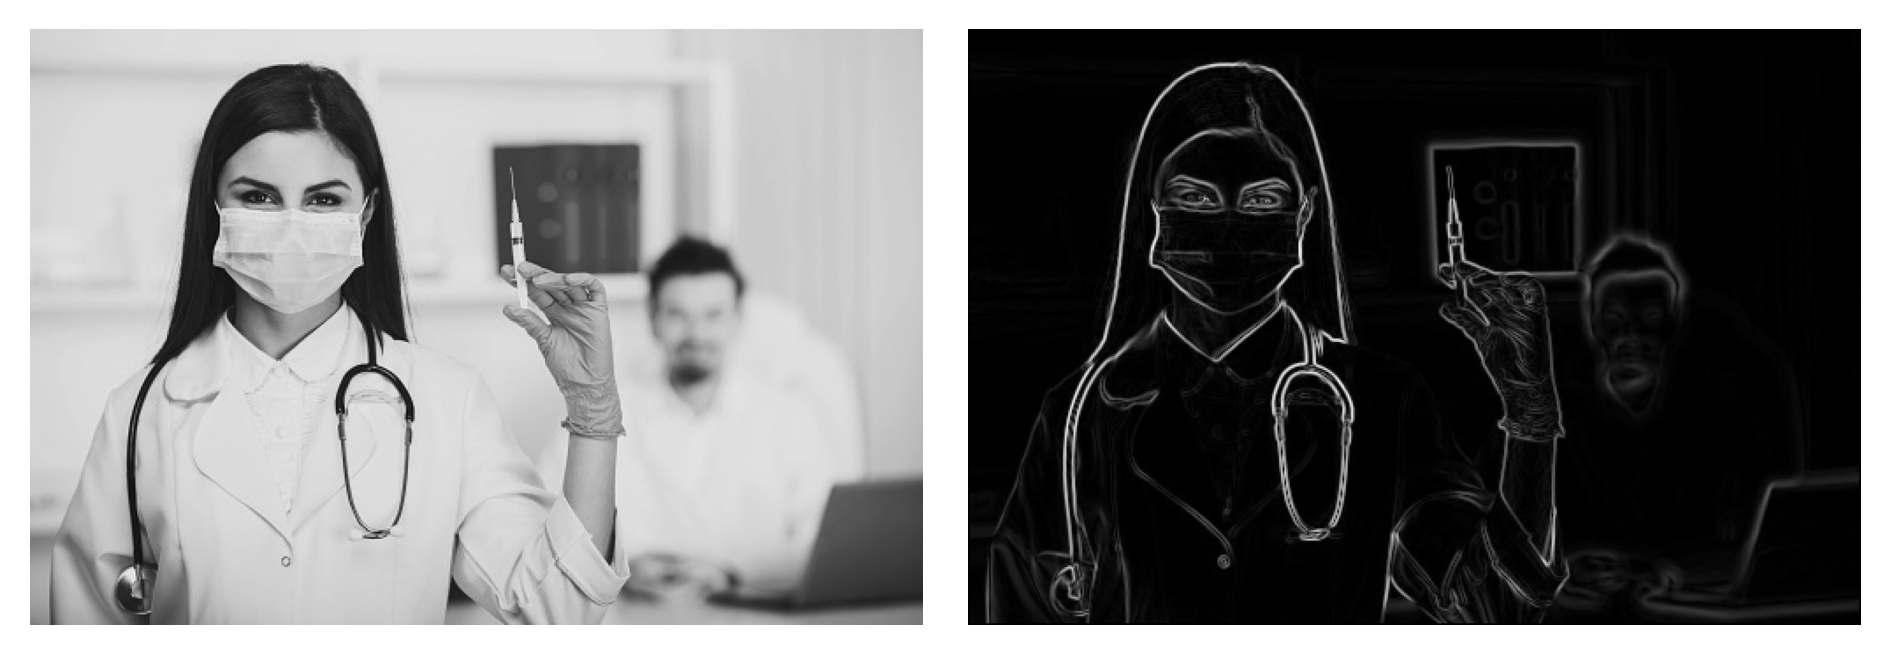

CPU times: user 1.41 s, sys: 16.9 ms, total: 1.42 s
Wall time: 1.42 s


In [14]:
%%time

edge_h = convolve_2D(test, sobel_h)
edge_v = convolve_2D(test, sobel_v)
edge_mag = np.sqrt(edge_h**2 + edge_v**2)

fig,ax=plt.subplots(1,2,dpi=300)
ax[0].imshow(test, cmap='gray')
ax[1].imshow(edge_mag,  cmap='gray')
for axi in ax:
    axi.axis('off')
fig.tight_layout()
plt.show()

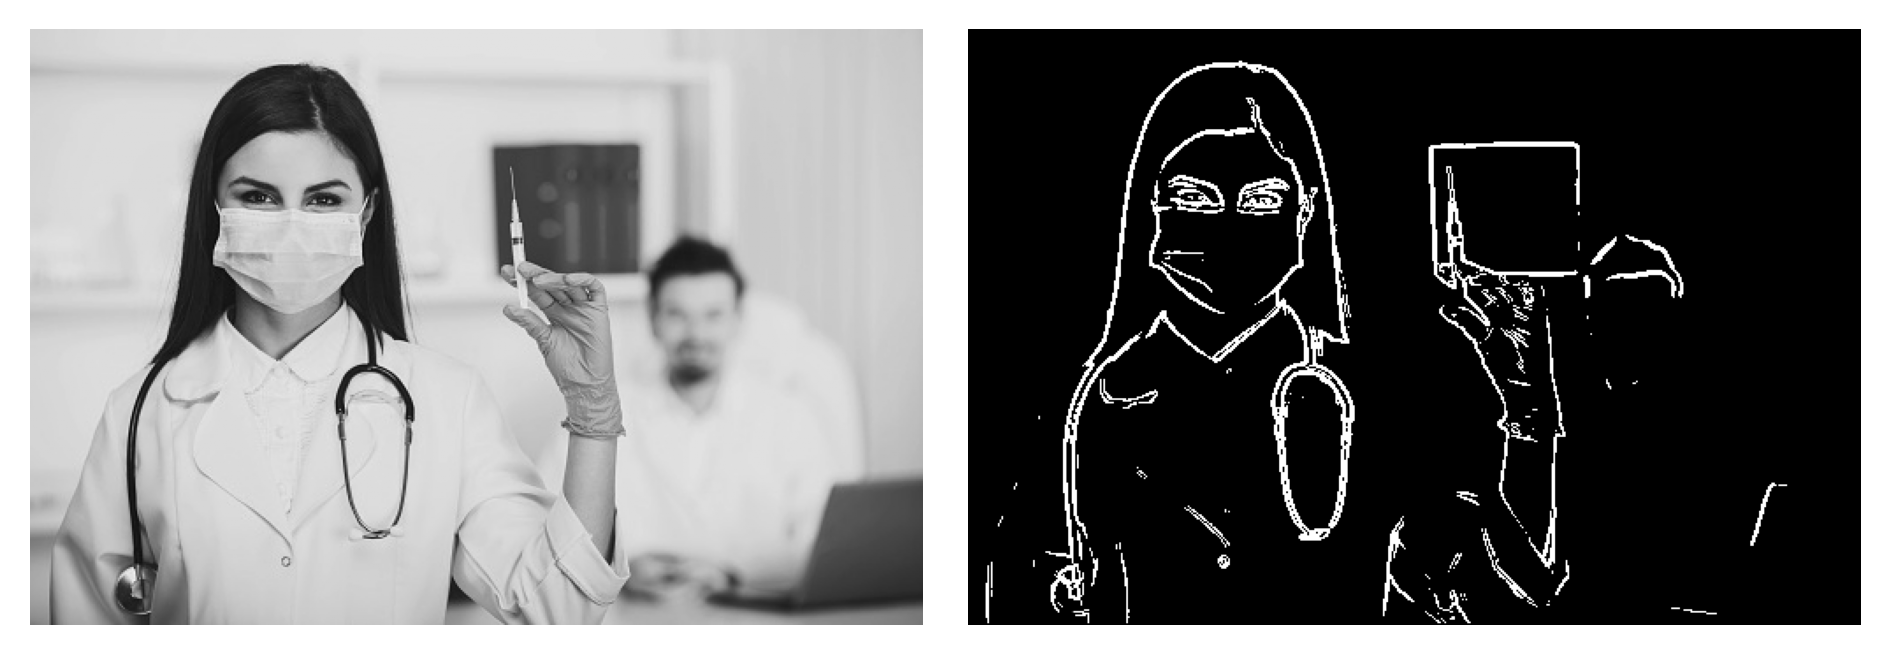

CPU times: user 150 ms, sys: 17.5 ms, total: 167 ms
Wall time: 175 ms


In [15]:
%%time

# Add an intensity threshold mask to get a binary "edge map"

t = 0.2  # try different values!
edge_mag = edge_mag/np.max(edge_mag)
edge_mag[edge_mag<t] = 0
edge_mag[edge_mag>t] = 1

fig, ax = plt.subplots(1, 2)
ax[0].imshow(test, cmap='gray')
ax[1].imshow(edge_mag,  cmap='gray')
for axi in ax:
    axi.axis('off')
fig.tight_layout()
plt.show()

# Application: Vision Simulator

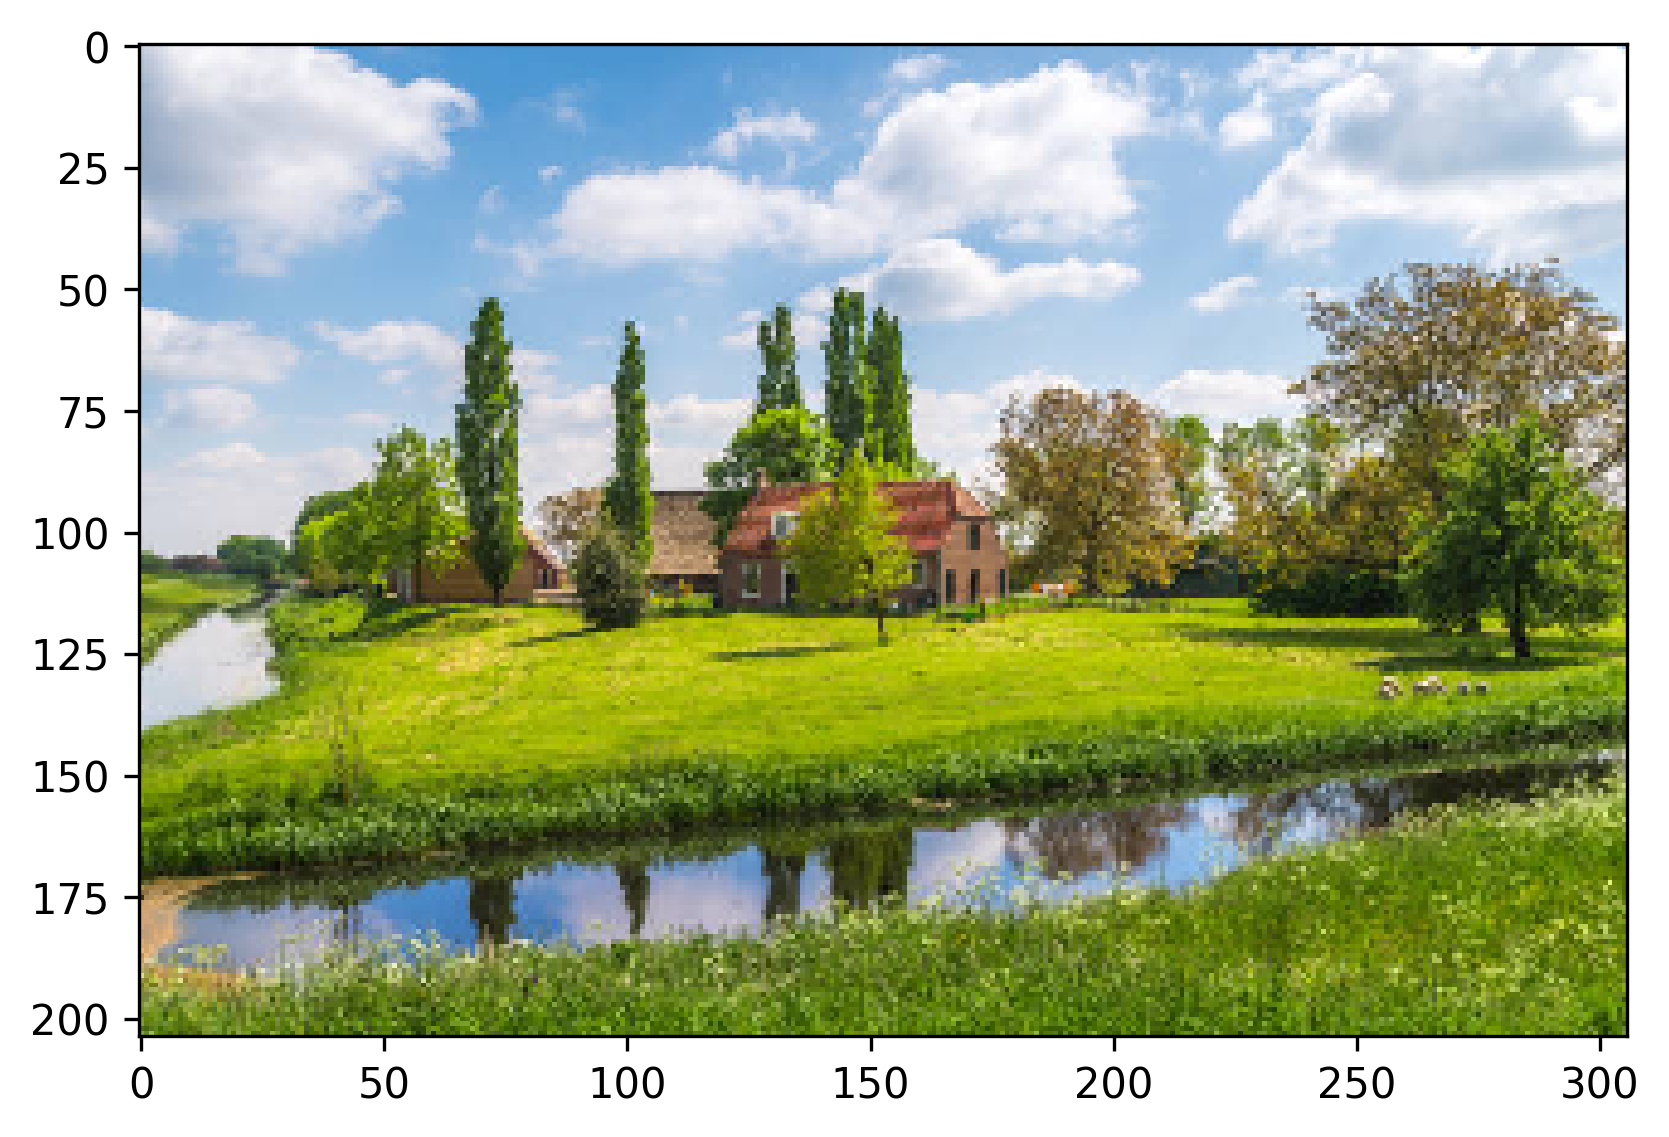

In [16]:
img_rgb = imageio.v2.imread('imgs/background.jpg')
img_rgb = np.array(img_rgb)
img_rgb = img_rgb[::2, ::2]
plt.imshow(img_rgb)
plt.show()

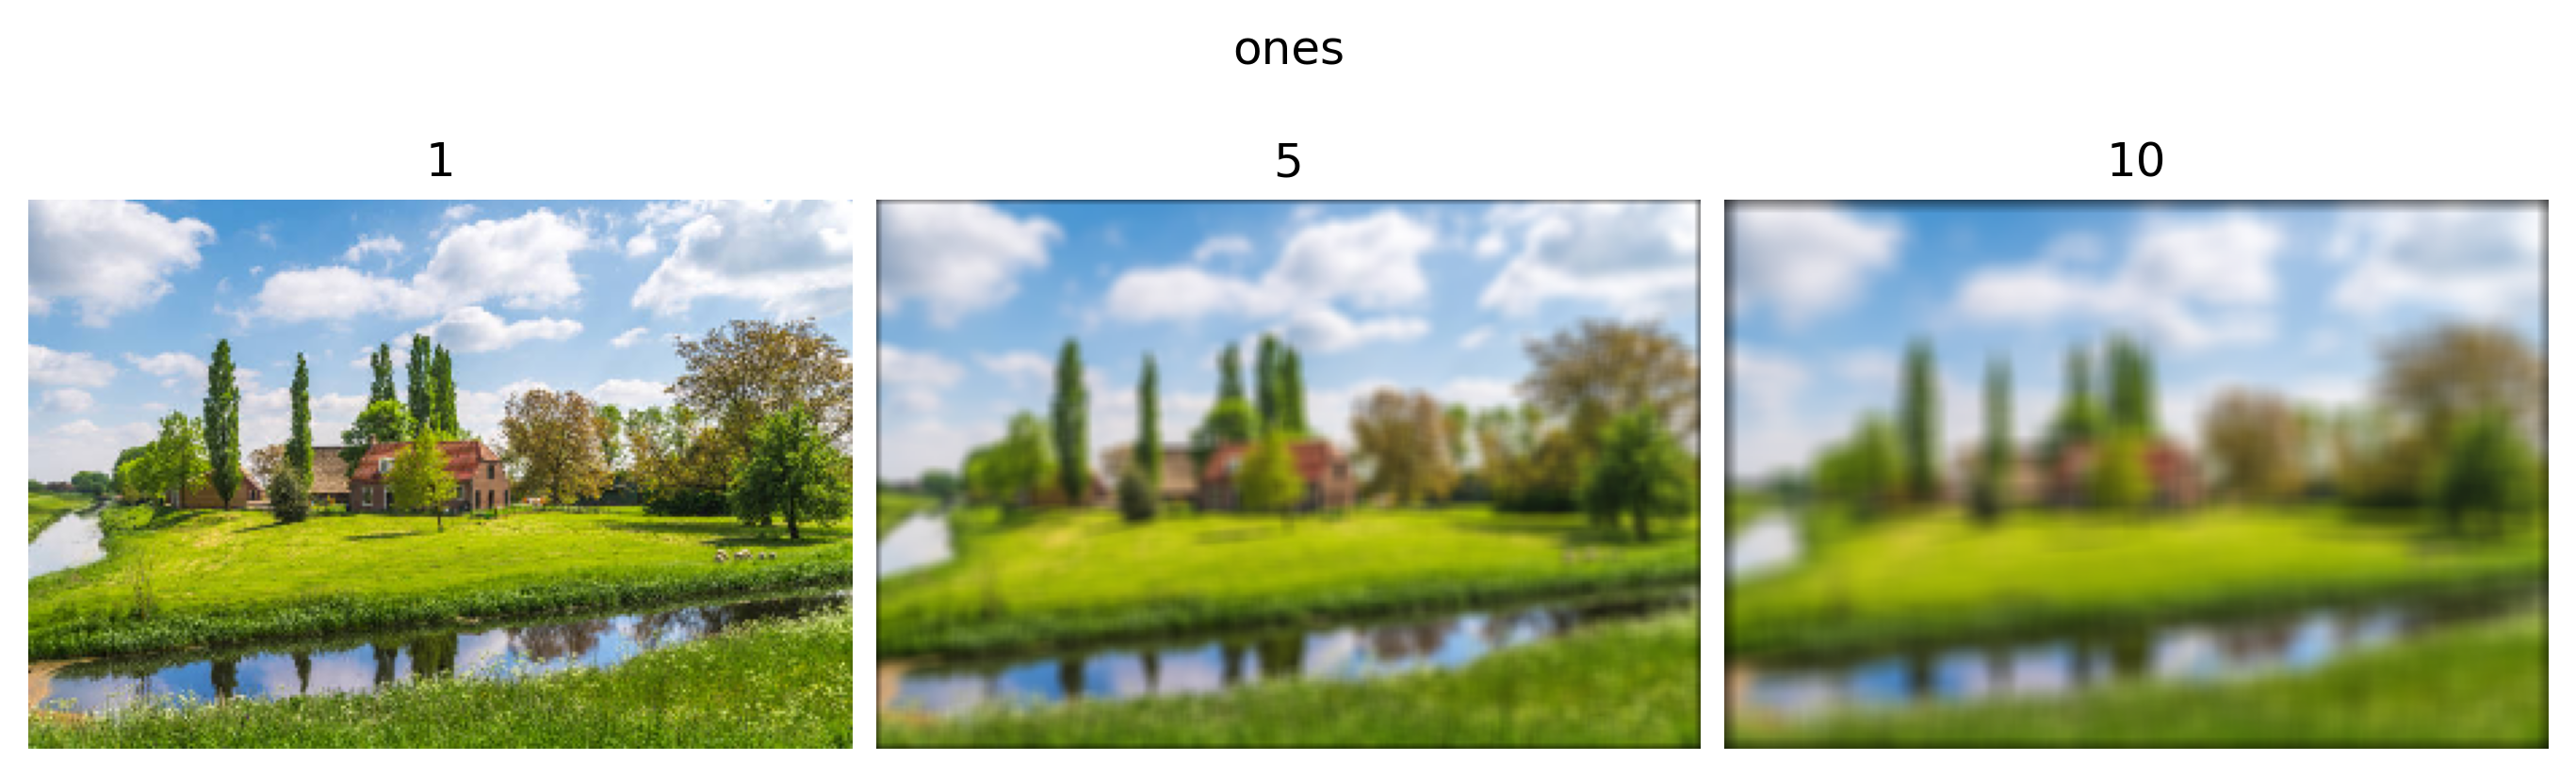

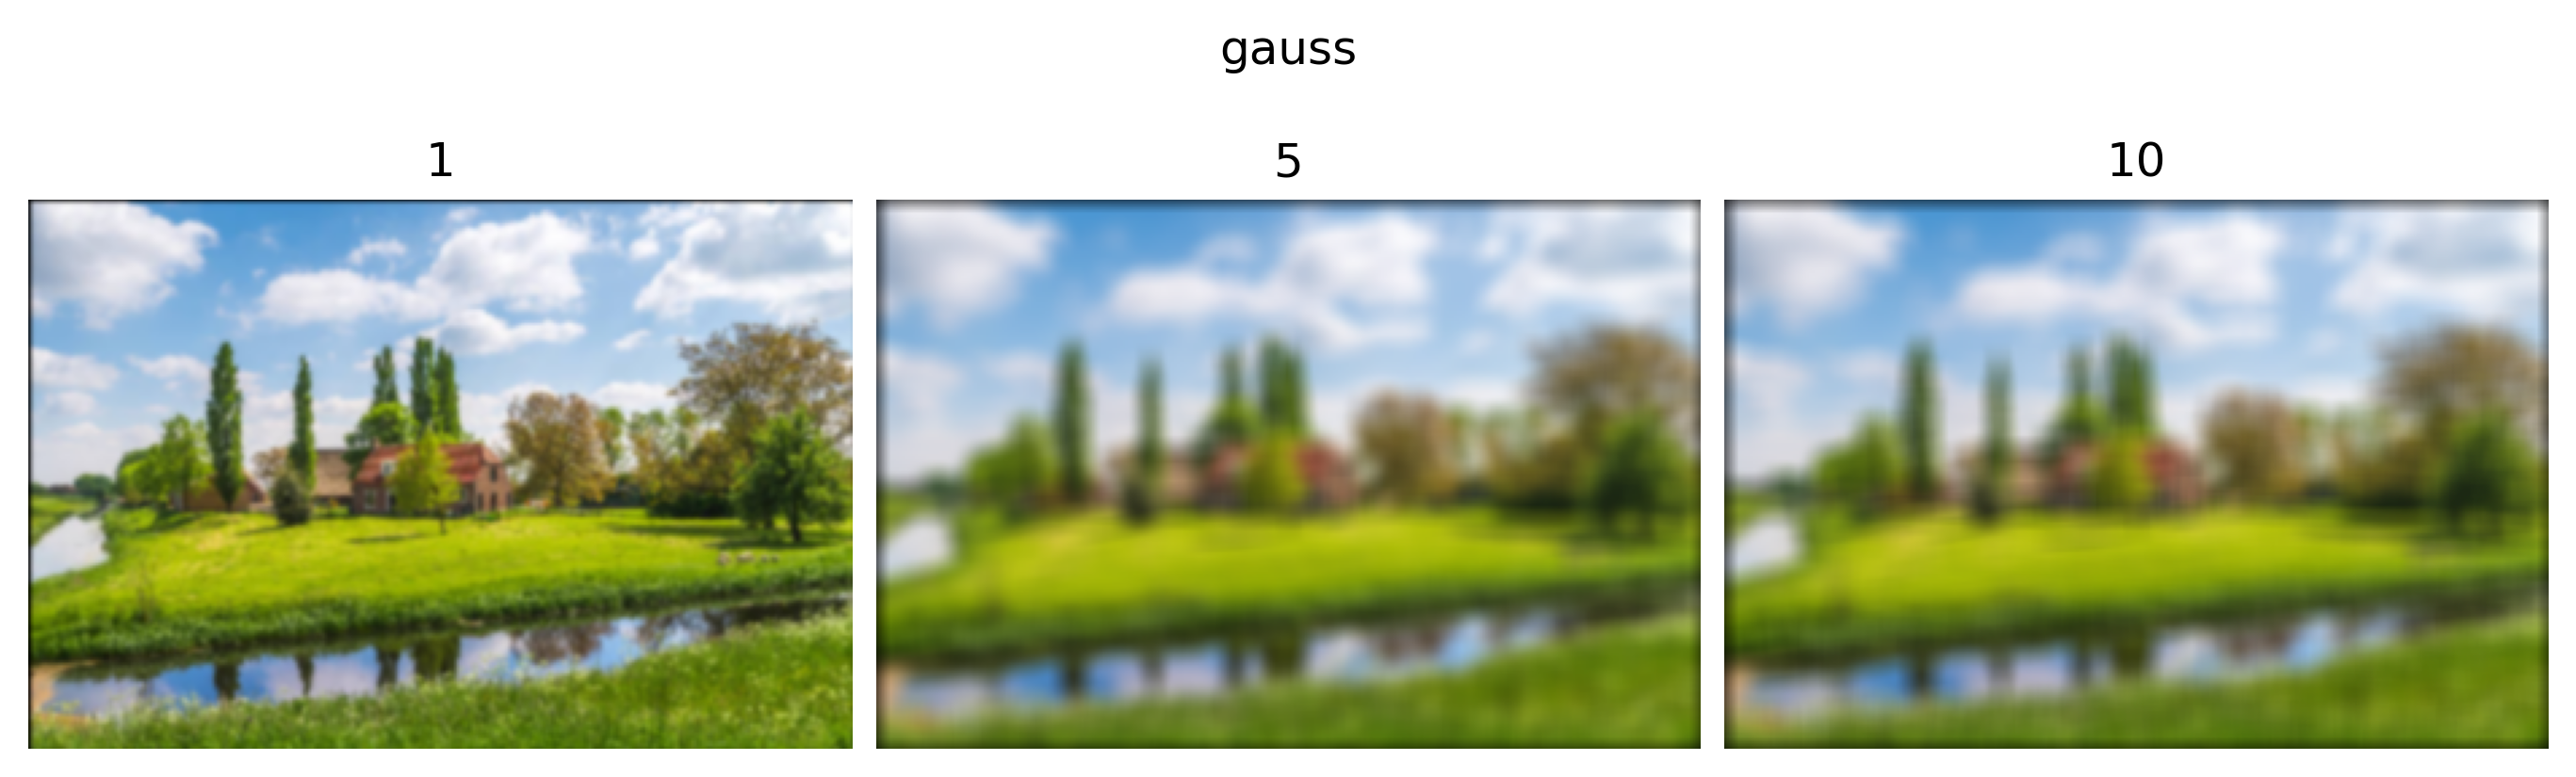

In [17]:
# %%time
def makeGaussian(size, fwhm = 3, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    kern =  np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    return kern
    
def simulate_vision(diopters, img=img_rgb, kerntype='ones'):
    N = abs(diopters)
    
    if kerntype == 'ones':
        kernel = np.ones((N, N)) 
    elif kerntype == 'gauss':
        kernel = makeGaussian(10, fwhm=N*2) 
        
    kernel /= np.sum(kernel)
    
    blurred = np.ones(img.shape, dtype=int)
    for i in range(3):
        blurred[...,i] = sp.signal.convolve2d(img[...,i], kernel, mode='same')
    return blurred


diops = [1, 5, 10]
for kerntype in ['ones', 'gauss']: 
    
    fig, ax = plt.subplots(1, len(diops), figsize=(9,3), layout='constrained')
    fig.suptitle(kerntype)
    for i in range(len(diops)): 
        out = simulate_vision(diops[i], kerntype=kerntype)
        ax[i].imshow(out)
        ax[i].axis('off')
        ax[i].set_title(f'{diops[i]}')
    plt.show()
